# Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader

from torch.utils.data import Sampler
import numpy as np
import random
from collections import defaultdict
import csv
import os
import json
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import numpy as np
import math
from torch.utils.data import Sampler, DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix



device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Inputs

In [ ]:
#shape (Num, Channels, Timesteps)
Input_path = '/kaggle/input/data-usa/Site_B/x-2020.npy' 
#shape (Num)
Labels_path = '/kaggle/input/data-usa/Site_B/y-2020.npy'

backbone_model_path = '/kaggle/input/active-learning-subset/backboneSiteA2019.pth'
fc_model_path = '/kaggle/input/active-learning-subset/fcSiteA2019.pth'

resume = False
checkpoint_path = "/kaggle/working/checkpoint_margin_samples400_round2_epoch1.pt"  # Replace with chekcpint file path to use
checkpoint_dir = "/kaggle/working/checkpoints"

"""
----------------------------------------------------------------------------------------
Loss Function selection
Currently available:
"ce = cross entropy loss","ls = LabelSmoothingCrossEntropyLoss"
"""
loss_mode = "ce"

"""
---------------------------------------------------------------------------------------------
Active Learning Method(s) to use
Currently available:
"random", "entropy", "margin", "least_confident", "diversity", "entropy_diversity"
"""
strategies = ["margin","entropy","entropy_diversity", "diversity"]

"""
----------------------------------------------------------------------------------------
Shape(s) of data to test on:
---(Initial samples, Iterations of AL loop, Query Sample Size)---
"""
data = [(4000,10,1000)]

subset_size = 0.25

batch_size = 64
epochs = 20
variable_epochs = False
eval_model_epochs = 10
test_size = 0.2
lr = 1e-3
weight_decay = 1e-4
label_smoothing = 0.1
ignore_index = -100

In [22]:
#prints how many labeled samples used, and how many samples will hte model effectively be trained on
def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init+query*iterations

print("Samples used: ",[total_labeled_samples(a, b, c) for a, b, c in data])
print("Effective Samples trained on: ",[eff_total_labeled_samples(a, b, c) for a, b, c in data])

Samples used:  [14000]
Effective Samples trained on:  [85000]


# Data Loader

In [23]:
def print_distribution(labels, name=""):
    counts = Counter(labels)
    total = sum(counts.values())
    print(f"Distribution in {name}:")
    for label in sorted(counts):
        pct = 100 * counts[label] / total
        print(f"  Class {label}: {counts[label]} ({pct:.1f}%)")


In [24]:
X = np.load(Input_path) 
y = np.load(Labels_path)

print("X", X.shape)
print("y", y.shape)

_, X, _, y = train_test_split(X, y, test_size=subset_size, stratify=y, random_state=42)

print("subset X", X.shape)
print("subset y", y.shape)

X (1943716, 28, 6)
y (1943716,)
subset X (485929, 28, 6)
subset y (485929,)


In [25]:
def compute_band_means_stds(X):
    """Compute per-band mean and std."""
    band_means = X.mean(axis=(0, 1))
    band_stds = X.std(axis=(0, 1))
    return band_means, band_stds


def print_stats_and_class_distribution(band_means, band_stds, y):
    """Print per-band stats and class distribution tables."""
    # Per-band stats
    df_stats = pd.DataFrame({
        'Band': [f'Band {i+1}' for i in range(len(band_means))],
        'Mean': band_means,
        'Std': band_stds
    })
    print("\nPer-Band Statistics:")
    print(df_stats.to_string(index=False))
    
    # Class distribution
    total_samples = len(y)
    class_counts = Counter(y)
    df_classes = pd.DataFrame({
        'Class': sorted(class_counts.keys()),
        'Count': [class_counts[c] for c in sorted(class_counts.keys())],
        'Percentage': [100 * class_counts[c] / total_samples for c in sorted(class_counts.keys())]
    })
    print("\nClass Distribution:")
    print(df_classes.to_string(index=False))



def normalize_data(X, band_means, band_stds):
    """Normalize data per band using provided means & stds."""
    band_means = band_means.reshape(1, 1, -1)
    band_stds = band_stds.reshape(1, 1, -1)
    return (X - band_means) / band_stds


def plot_band_histograms(X, bins=100):
    """Plot histograms for each band in a compact grid layout."""
    n_bands = X.shape[2]
    cols = 3  # number of histograms per row
    rows = math.ceil(n_bands / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for b in range(n_bands):
        axes[b].hist(X[:, :, b].ravel(), bins=bins, color='blue', alpha=0.7)
        axes[b].set_title(f'Band {b+1}')
        axes[b].set_xlabel('Value')
        axes[b].set_ylabel('Freq')

    # Hide any unused subplots
    for i in range(n_bands, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def compute_class_weights(y, device=device):
    y = np.asarray(y)
    n_classes = int(y.max()) + 1  # infer number of classes

    class_counts = np.bincount(y, minlength=n_classes)
    total_samples = len(y)

    # Avoid division by zero
    class_counts[class_counts == 0] = 1  

    # Inverse frequency
    weights = total_samples / (n_classes * class_counts)

    weights = torch.tensor(weights, dtype=torch.float32)
    if device is not None:
        weights = weights.to(device)
    return weights


Before Normalisation

Global Mean: 13126.3795
Global Std Dev: 4498.5529

Per-Band Statistics:
  Band         Mean         Std
Band 1  9292.621891 1061.369046
Band 2 10401.063186 1327.229642
Band 3 10577.446920 1997.853274
Band 4 18965.798483 4272.048195
Band 5 16317.102755 3344.065880
Band 6 13204.243939 3493.070163

Class Distribution:
 Class  Count  Percentage
     0 217758   44.812720
     1  65194   13.416363
     2 202977   41.770917


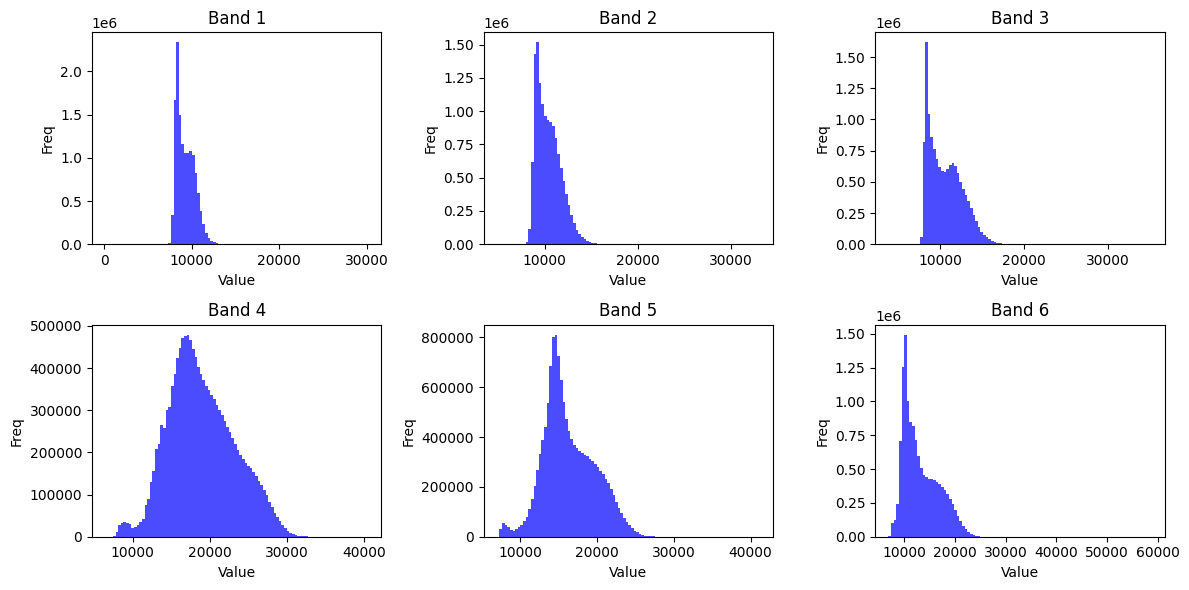

After Normalisation

Global Mean: 0.0000
Global Std Dev: 1.0000

Per-Band Statistics:
  Band          Mean  Std
Band 1 -3.562657e-14  1.0
Band 2  1.205601e-13  1.0
Band 3 -2.153750e-13  1.0
Band 4  1.449979e-13  1.0
Band 5  7.717450e-14  1.0
Band 6 -6.081873e-14  1.0

Class Distribution:
 Class  Count  Percentage
     0 217758   44.812720
     1  65194   13.416363
     2 202977   41.770917


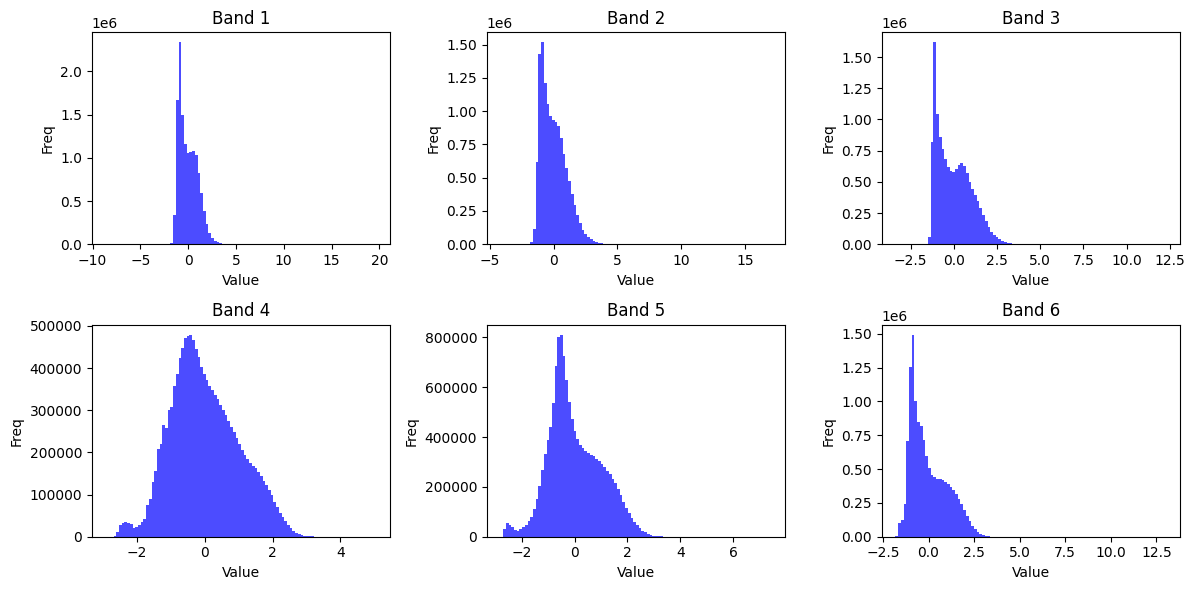

Class Weights: tensor([0.7438, 2.4845, 0.7980], device='cuda:0')


In [26]:
print("Before Normalisation")
print(f"\nGlobal Mean: {X.mean():.4f}")
print(f"Global Std Dev: {X.std():.4f}")
band_means, band_stds = compute_band_means_stds(X)
print_stats_and_class_distribution(band_means, band_stds, y)
plot_band_histograms(X)

X = normalize_data(X, band_means, band_stds)

print("After Normalisation")
print(f"\nGlobal Mean: {X.mean():.4f}")
print(f"Global Std Dev: {X.std():.4f}")
band_means, band_stds = compute_band_means_stds(X)
print_stats_and_class_distribution(band_means, band_stds, y)
plot_band_histograms(X)


class_weights = compute_class_weights(y, device=device)
print(f"Class Weights: {class_weights}")


# Dataset

In [27]:
X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)


print("X pool", X_pool.shape)
print("y_pool", y_pool.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)

X pool (388743, 28, 6)
y_pool (388743,)
X_val (97186, 28, 6)
y_val (97186,)


In [28]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X.transpose(0,2,1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

# Loss Functions

In [29]:
class Loss:
    def __init__(self, weight=None, ignore_index=-100, device=None, smoothing=0.1):
        self.weight = weight
        self.ignore_index = ignore_index
        self.device = device
        self.smoothing = smoothing
        self.criterion = None
        self.loss_func = None

    def build(self, mode='ce'):
        """
        Available modes: 'ce', 'ls'
        """
        if mode == 'ce':
            self.criterion = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index)
            self.loss_func = self.cross_entropy_loss

        elif mode == 'ls':
            self.loss_func = self.label_smoothing_loss

        else:
            raise NotImplementedError(f"Loss mode '{mode}' is not implemented.")

        if self.device is not None and self.criterion is not None:
            self.criterion = self.criterion.to(self.device)

        return self.loss_func

    def cross_entropy_loss(self, logits, targets):
        return self.criterion(logits, targets)

    def label_smoothing_loss(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        
        valid = targets != self.ignore_index
        log_probs = log_probs[valid]
        targets = targets[valid]
        
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = (1.0 - self.smoothing) * nll_loss + self.smoothing * smooth_loss
    
        if self.weight is not None:
            weight = self.weight.to(logits.device)
            loss = loss * weight[targets]
    
        return loss.mean()


# Model

In [30]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int, dropout=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5, padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x

 
################ Fully connected network
class FC(nn.Module):
    def __init__(self, input_dim):
        super(FC, self).__init__()
        self.dropout = nn.Dropout(0.3)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        x = self.fco(x)
        return x



class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

In [31]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load(backbone_model_path, map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load(fc_model_path, map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)
initial_state_dict = copy.deepcopy(model.state_dict())

# Active Learning methods

In [32]:
def query_samples(model, dataset, query_size, strategy, device, already_selected_idx=None):
    model.eval()

    #check if strategy is correct
    strategy = strategy.strip().lower()
    allowed_strategies = [
        "entropy", "least_confident", "margin", "random",
        "diversity", "density", "entropy_diversity"
    ]
    
    if strategy not in allowed_strategies:
        raise ValueError(f"[ERROR] Unknown strategy '{strategy}'. Must be one of: {allowed_strategies}")

    
    dataloader = DataLoader(dataset, batch_size=128)
    all_scores = []
    all_features = []
    if already_selected_idx is None:
        already_selected_idx = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["x"].to(device)
            features, out = model(x)
            probs = F.softmax(out, dim=1)

            if strategy in ["entropy", "least_confident", "margin", "random", "entropy_diversity"]:
                score = None
                if strategy in ["entropy", "entropy_diversity"]:
                    score = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
                elif strategy == "least_confident":
                    score = 1 - probs.max(dim=1)[0]
                elif strategy == "margin":
                    sorted_probs, _ = probs.sort(dim=1, descending=True)
                    score = -(sorted_probs[:, 0] - sorted_probs[:, 1])
                elif strategy == "random":
                    score = torch.rand(len(x), device=device)

                all_scores.extend(score.cpu().numpy())

            if strategy in ["diversity", "density", "entropy_diversity"]:
                all_features.append(features.cpu().numpy())

    if strategy in ["entropy", "least_confident", "margin", "random"]:
        indices = np.argsort(all_scores)[-query_size:]
        return indices

    all_features = np.concatenate(all_features, axis=0)

    if strategy == "diversity":
        if already_selected_idx is None or len(already_selected_idx) == 0:
            selected = [torch.randint(0, len(all_features), (1,), device=device).item()]
        else:
            selected = already_selected_idx.copy()

        # make sure features are torch tensor on GPU
        if isinstance(all_features, np.ndarray):
            all_features = torch.from_numpy(all_features)
        all_features = all_features.to(device)

        # mask for remaining points
        remaining_mask = torch.ones(len(all_features), dtype=torch.bool, device=device)
        remaining_mask[selected] = False

        # initialize min distances wrt selected
        selected_features = all_features[selected]
        dists = torch.cdist(all_features, selected_features)  # [N, |selected|]
        min_dists = torch.min(dists, dim=1).values

        for _ in range(query_size):
            # pick farthest among remaining
            masked_dists = min_dists.clone()
            masked_dists[~remaining_mask] = -1
            next_idx = torch.argmax(masked_dists).item()
            selected.append(next_idx)

            # update mask and distances
            remaining_mask[next_idx] = False
            new_dist = torch.cdist(all_features, all_features[next_idx:next_idx+1]).squeeze(1)
            min_dists = torch.minimum(min_dists, new_dist)

        new_indices = list(set(selected) - set(already_selected_idx))[-query_size:]
        return np.array(new_indices)


    elif strategy == "entropy_diversity":
        # Hybrid: Select top-2×query_size most uncertain samples, then apply core-set
        all_scores = np.array(all_scores)

        # convert features to torch tensor on GPU
        if isinstance(all_features, np.ndarray):
            all_features = torch.from_numpy(all_features)
        all_features = all_features.to(device)

        top_uncertain_idx = np.argsort(all_scores)[-2 * query_size:]
        uncertain_features = all_features[top_uncertain_idx]

        # Core-set on uncertain samples
        selected = [torch.randint(0, len(uncertain_features), (1,), device=device).item()]

        remaining_mask = torch.ones(len(uncertain_features), dtype=torch.bool, device=device)
        remaining_mask[selected] = False

        selected_features = uncertain_features[selected]
        dists = torch.cdist(uncertain_features, selected_features)
        min_dists = torch.min(dists, dim=1).values

        for _ in range(query_size - 1):
            masked_dists = min_dists.clone()
            masked_dists[~remaining_mask] = -1
            next_idx = torch.argmax(masked_dists).item()
            selected.append(next_idx)

            remaining_mask[next_idx] = False
            new_dist = torch.cdist(uncertain_features, uncertain_features[next_idx:next_idx+1]).squeeze(1)
            min_dists = torch.minimum(min_dists, new_dist)

        final_indices = top_uncertain_idx[selected]
        return np.array(final_indices)


# Train/eval loop

In [33]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []
    
    for batch in dataloader:
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, loss_fn=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if loss_fn:
                total_loss += loss_fn(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if loss_fn:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1


In [34]:
def plot_round_metrics(history):
    round_id = len(history["rounds"]) - 1
    round_data = history["rounds"][round_id]
    epoch_stats = round_data["epoch_metrics"]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id + 1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id + 1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id + 1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_final_performance(history):
    samples = [r["num_labeled_samples"] for r in history["rounds"]]
    val_acc = [r["final_val"]["acc"] for r in history["rounds"]]
    val_f1 = [r["final_val"]["avg_f1"] for r in history["rounds"]]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples, val_acc, marker='o')
    plt.title("Val Accuracy vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(samples, val_f1, marker='o')
    plt.title("Val Avg F1 vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1")

    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt

def plot_fresh_model_metrics(epoch_stats):
    epochs = [e["epoch"] for e in epoch_stats]
    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    # Loss plot
    plt.figure()
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Fresh Model Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy plot
    plt.figure()
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Fresh Model Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # F1 plot
    plt.figure()
    plt.plot(epochs, train_f1, label="Train Avg F1")
    plt.plot(epochs, val_f1, label="Val Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Fresh Model F1 Score")
    plt.legend()
    plt.grid(True)
    plt.show()



In [35]:

def save_checkpoint(model, optimizer, history, iteration, epoch, labeled_samples,
                    strategy, tot_samples, checkpoint_dir = checkpoint_dir, last_checkpoint_path=None):

    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Define new checkpoint filename with iter and epoch
    filename = f"checkpoint_{strategy}_samples{tot_samples}_round{iteration}_epoch{epoch}.pt"
    checkpoint_path = os.path.join(checkpoint_dir, filename)

    # Save checkpoint content
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "history": history,
        "iteration": iteration,
        "epoch": epoch,
        "labeled_samples": labeled_samples
    }
    torch.save(checkpoint, checkpoint_path)

    # Delete previous checkpoint if it exists and is different
    if last_checkpoint_path and os.path.exists(last_checkpoint_path) and last_checkpoint_path != checkpoint_path:
        os.remove(last_checkpoint_path)

    return checkpoint_path



def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    history = checkpoint["history"]
    iteration = checkpoint["iteration"]
    epoch = checkpoint["epoch"]
    labeled_samples = checkpoint["labeled_samples"]

    return model, optimizer, history, iteration, epoch, labeled_samples

def load_checkpoint_data(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only = False)
    labeled_samples = checkpoint["labeled_samples"]

    return labeled_samples


def save_history_to_txt(history, strategy, tot_samples, init ,iters, query_size):
    os.makedirs("logs", exist_ok=True)
    file_path = f"logs/{strategy}_{tot_samples}_{init}_{iters}_{query_size}.txt"
    with open(file_path, "w") as f:
        json.dump(history, f, indent=2)

# Active Learning Loop

In [36]:
def active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy, device, iters=10, query_size=100, final_epochs=10, loss_mode='ce', batch_size=16):
    init = len(labeled_dataset)
    tot_samples = total_labeled_samples(init, iters, query_size)
    eff_tot_samples = eff_total_labeled_samples(init, iters, query_size)

    loss_handler = Loss(weight=class_weights, ignore_index=ignore_index, device=device, smoothing=label_smoothing)
    loss_fn = loss_handler.build(mode=loss_mode)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    
    if resume and os.path.exists(checkpoint_path):
        model, optimizer, history, start_iter, start_epoch, labeled_samples = load_checkpoint(
            model, optimizer, checkpoint_path, device)
        print(f"Resuming from checkpoint at iteration {start_iter}, epoch {start_epoch}")
    else:
        history = {
            "strategy": strategy,
            "initial_samples": init,
            "query_size": query_size,
            "total_iterations": iters,
            "total_samples": tot_samples,
            "effective_total_samples": eff_tot_samples,
            "rounds": []
        }
        start_iter = 0

    for it in range(start_iter, iters):
        print(f"\n[AL Round {it}/{iters - 1}] — Labeled samples: {len(labeled_dataset)}")
        train_loader = DataLoader(labeled_dataset, batch_size=batch_size)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        epoch_stats = []
        epochs = final_epochs

        if variable_epochs:
            if it <= 2:
                epochs = 7
            elif 3 <= it <= 5:
                epochs = 10
            else:
                epochs = final_epochs

        last_checkpoint_path = None

        for ep in tqdm(range(epochs), desc="Epoch", leave=False):
            tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
            val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, loss_fn)

            epoch_stats.append({
                "epoch": ep,
                "train_loss": tr_loss,
                "train_acc": tr_acc,
                "train_avg_f1": tr_avgf1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_avg_f1": val_avgf1
            })

                     
            last_checkpoint_path = save_checkpoint(
                model=model,
                optimizer=optimizer,
                history=history,
                iteration=it,
                epoch=ep,
                labeled_samples=len(labeled_dataset),
                strategy=strategy,
                tot_samples=tot_samples,
                last_checkpoint_path=last_checkpoint_path
            )

            scheduler.step(val_loss)


        # Compute full confusion matrix and per-class F1
        all_preds, all_true = [], []
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                X_batch = batch["x"].to(device)
                y_batch = batch["y"].to(device)
                _, logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_true.extend(y_batch.cpu().numpy())

        conf_mat = confusion_matrix(all_true, all_preds).tolist()
        f1_per_class = f1_score(all_true, all_preds, average=None).tolist()

        history["rounds"].append({
            "round": it,
            "num_labeled_samples": len(labeled_dataset),
            "epoch_metrics": epoch_stats,
            "final_train": {
                "loss": tr_loss,
                "acc": tr_acc,
                "avg_f1": tr_avgf1
            },
            "final_val": {
                "loss": val_loss,
                "acc": val_acc,
                "avg_f1": val_avgf1,
                "f1_per_class": f1_per_class,
                "confusion_matrix": conf_mat
            }
        })

        save_history_to_txt(history, strategy, tot_samples, init ,iters, query_size)

        if len(unlabeled_dataset) < query_size:
            print("Unlabeled pool exhausted.")
            break

        selected_idxs = query_samples(model, unlabeled_dataset, query_size, strategy, device)
        new_x = [unlabeled_dataset.X[i] for i in selected_idxs]
        new_y = [unlabeled_dataset.y[i] for i in selected_idxs]

        labeled_dataset.X = torch.cat([labeled_dataset.X, torch.stack(new_x)], dim=0)
        labeled_dataset.y = torch.cat([labeled_dataset.y, torch.tensor(new_y)], dim=0)

        keep_idxs = list(set(range(len(unlabeled_dataset))) - set(selected_idxs))
        unlabeled_dataset.X = torch.stack([unlabeled_dataset.X[i] for i in keep_idxs])
        unlabeled_dataset.y = torch.tensor([unlabeled_dataset.y[i] for i in keep_idxs])

        print(f"\nEpoch {epochs}/{epochs}")
        print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
        print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")

        plot_round_metrics(history)

    plot_final_performance(history)
    
    save_history_to_txt(history, strategy, tot_samples, init ,iters, query_size)
    return history

X_labeled shape: (4000, 28, 6)
y_labeled shape: (4000,)
Distribution in X_labeled:
  Class 0: 1792 (44.8%)
  Class 1: 537 (13.4%)
  Class 2: 1671 (41.8%)
X_unlabeled shape: (384743, 28, 6)
y_unlabeled shape: (384743,)
Distribution in X_unlabeled:
  Class 0: 172414 (44.8%)
  Class 1: 51618 (13.4%)
  Class 2: 160711 (41.8%)

=== Running strategy: MARGIN ===

[AL Round 0/9] — Labeled samples: 4000



Epoch 20/20
Train — Loss: 0.2139 | Acc: 0.9025 | Avg F1: 0.9080
Val   — Loss: 0.3474 | Acc: 0.8830 | Avg F1: 0.8830


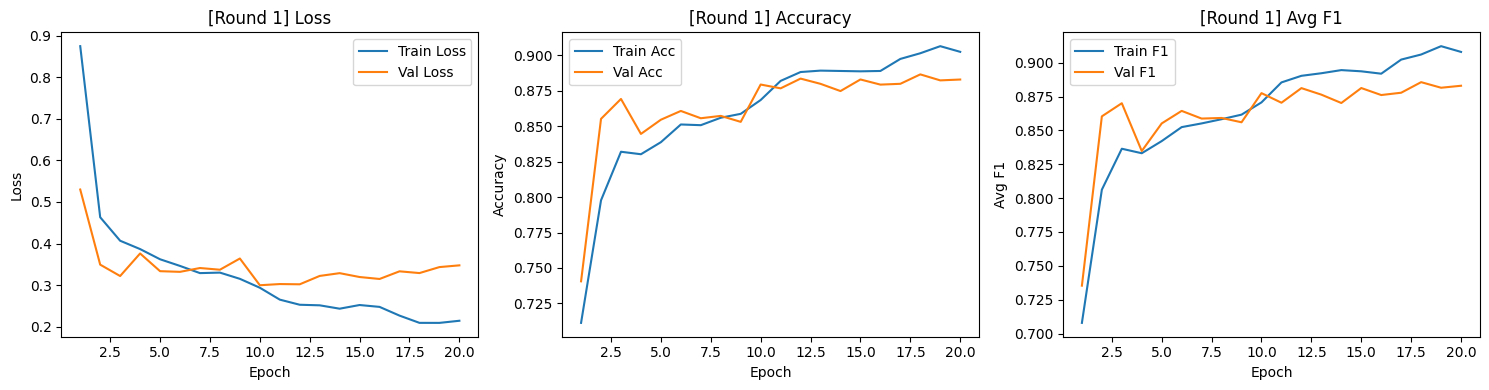


[AL Round 1/9] — Labeled samples: 5000



Epoch 20/20
Train — Loss: 0.2753 | Acc: 0.8750 | Avg F1: 0.8790
Val   — Loss: 0.3467 | Acc: 0.8946 | Avg F1: 0.8954


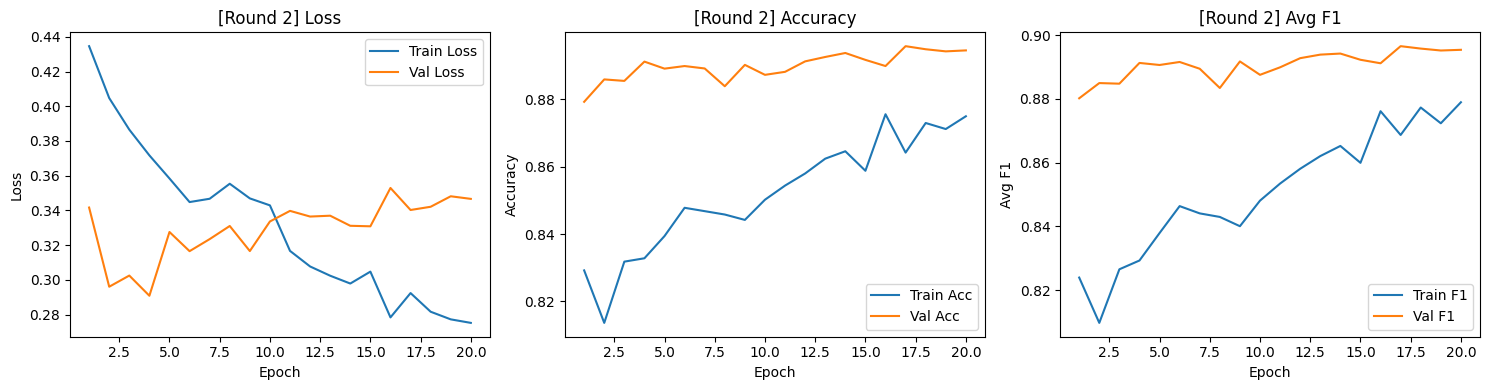


[AL Round 2/9] — Labeled samples: 6000



Epoch 20/20
Train — Loss: 0.3659 | Acc: 0.8363 | Avg F1: 0.8343
Val   — Loss: 0.3092 | Acc: 0.9002 | Avg F1: 0.9007


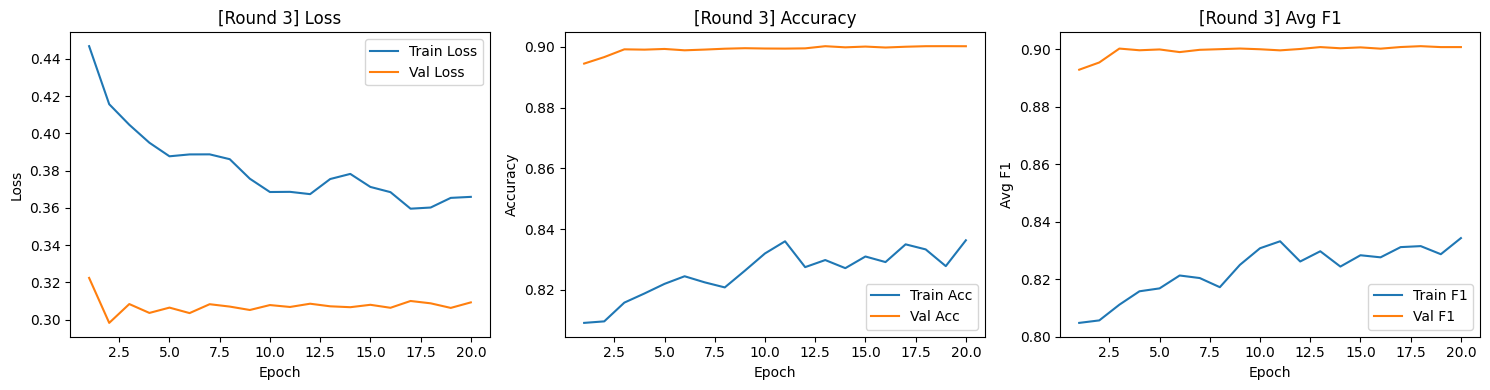


[AL Round 3/9] — Labeled samples: 7000



Epoch 20/20
Train — Loss: 0.4566 | Acc: 0.7786 | Avg F1: 0.7716
Val   — Loss: 0.3008 | Acc: 0.9009 | Avg F1: 0.9008


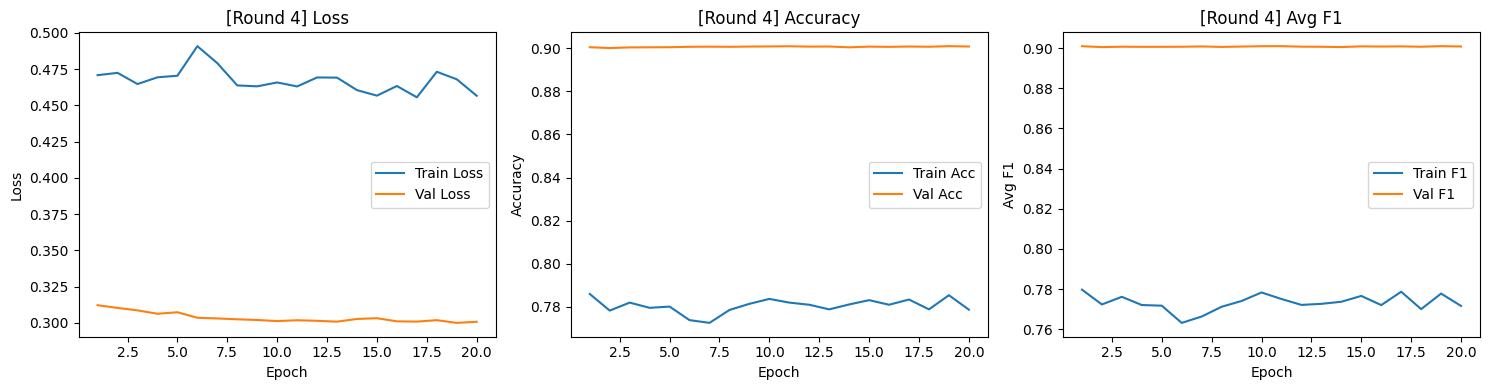


[AL Round 4/9] — Labeled samples: 8000



Epoch 20/20
Train — Loss: 0.5486 | Acc: 0.7428 | Avg F1: 0.7308
Val   — Loss: 0.3016 | Acc: 0.9008 | Avg F1: 0.9013


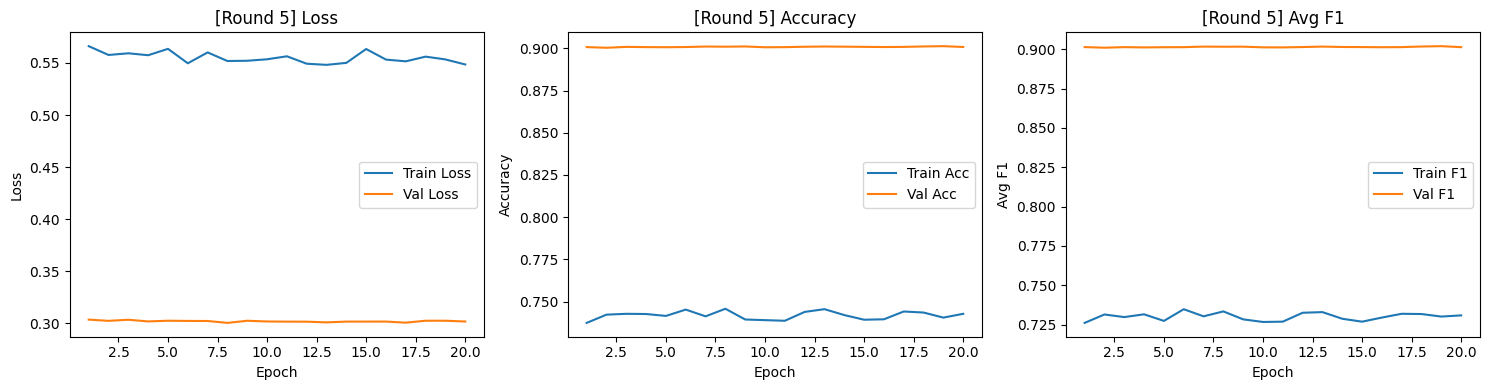


[AL Round 5/9] — Labeled samples: 9000



Epoch 20/20
Train — Loss: 0.6065 | Acc: 0.7130 | Avg F1: 0.7000
Val   — Loss: 0.2917 | Acc: 0.9018 | Avg F1: 0.9019


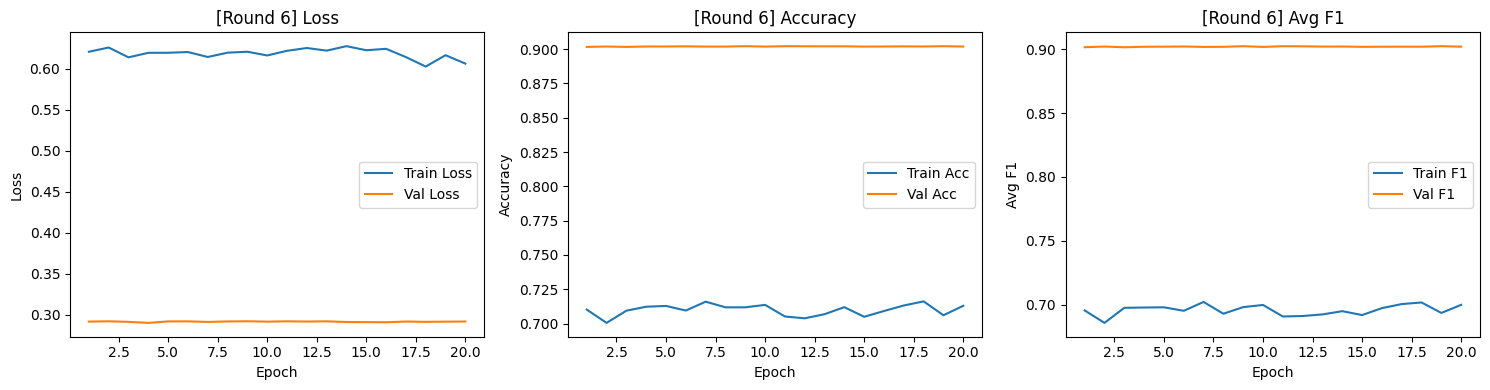


[AL Round 6/9] — Labeled samples: 10000



Epoch 20/20
Train — Loss: 0.6781 | Acc: 0.6834 | Avg F1: 0.6654
Val   — Loss: 0.2931 | Acc: 0.9017 | Avg F1: 0.9017


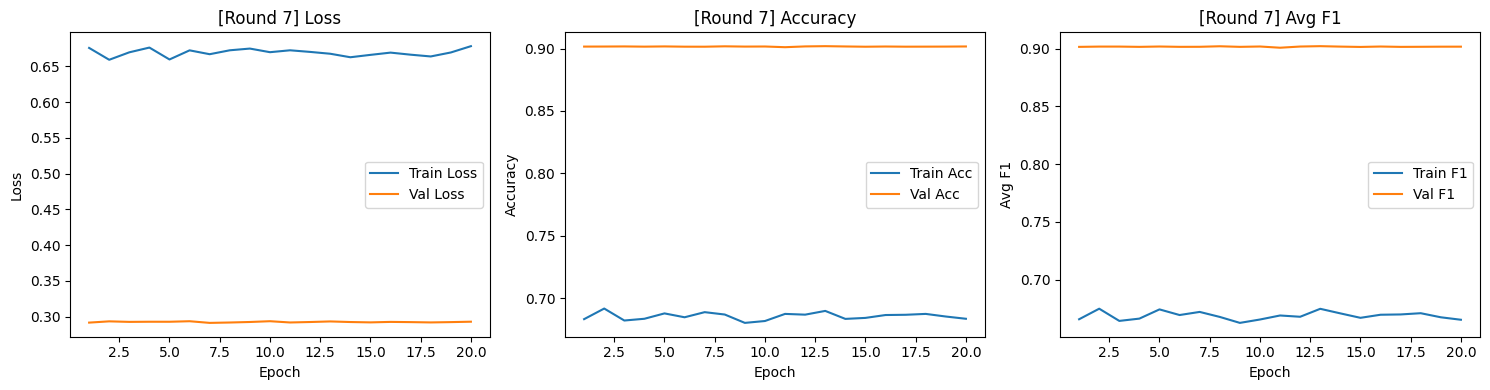


[AL Round 7/9] — Labeled samples: 11000



Epoch 20/20
Train — Loss: 0.7131 | Acc: 0.6605 | Avg F1: 0.6433
Val   — Loss: 0.3017 | Acc: 0.9000 | Avg F1: 0.9004


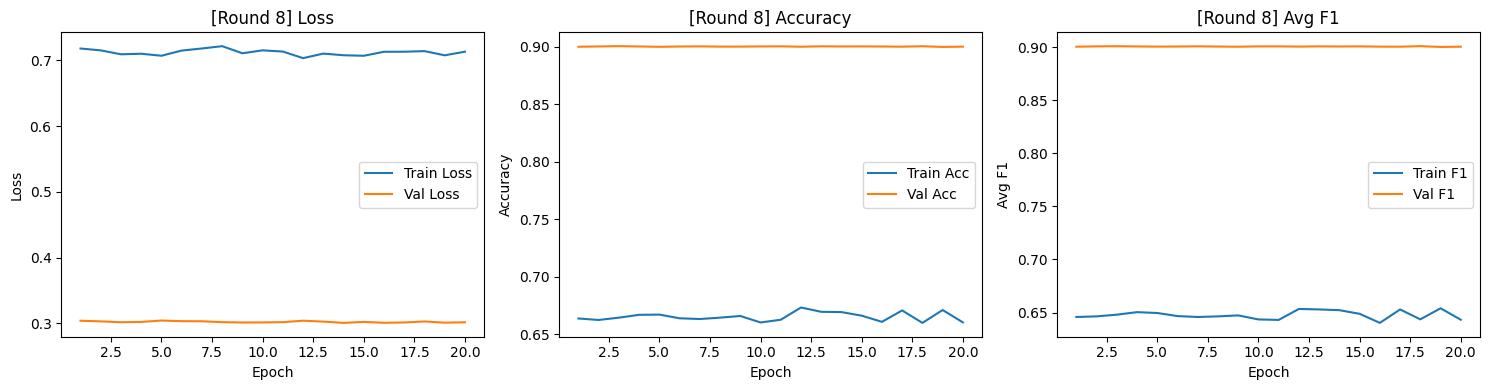


[AL Round 8/9] — Labeled samples: 12000



Epoch 20/20
Train — Loss: 0.7523 | Acc: 0.6506 | Avg F1: 0.6302
Val   — Loss: 0.2951 | Acc: 0.9012 | Avg F1: 0.9017


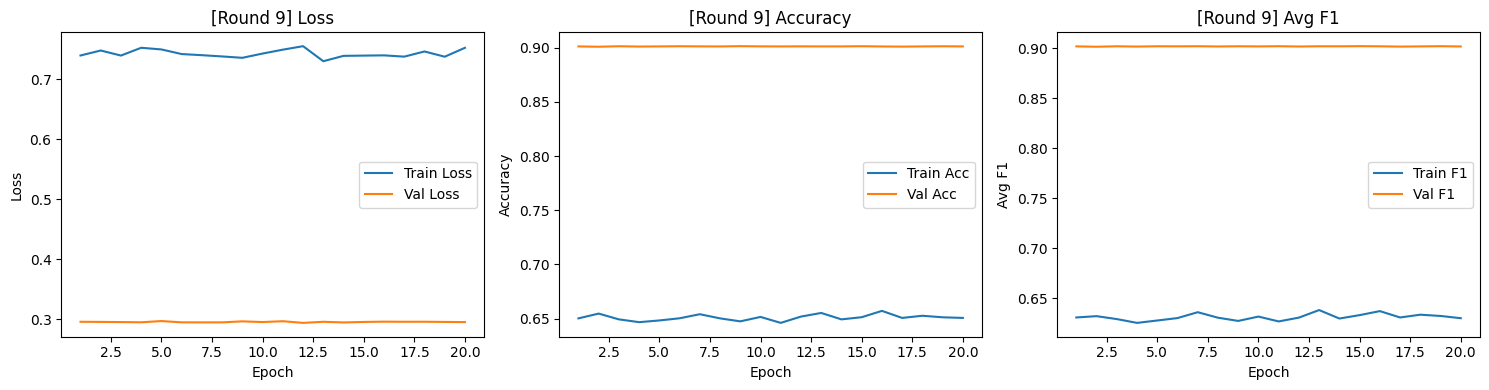


[AL Round 9/9] — Labeled samples: 13000



Epoch 20/20
Train — Loss: 0.7706 | Acc: 0.6366 | Avg F1: 0.6187
Val   — Loss: 0.2960 | Acc: 0.9006 | Avg F1: 0.9012


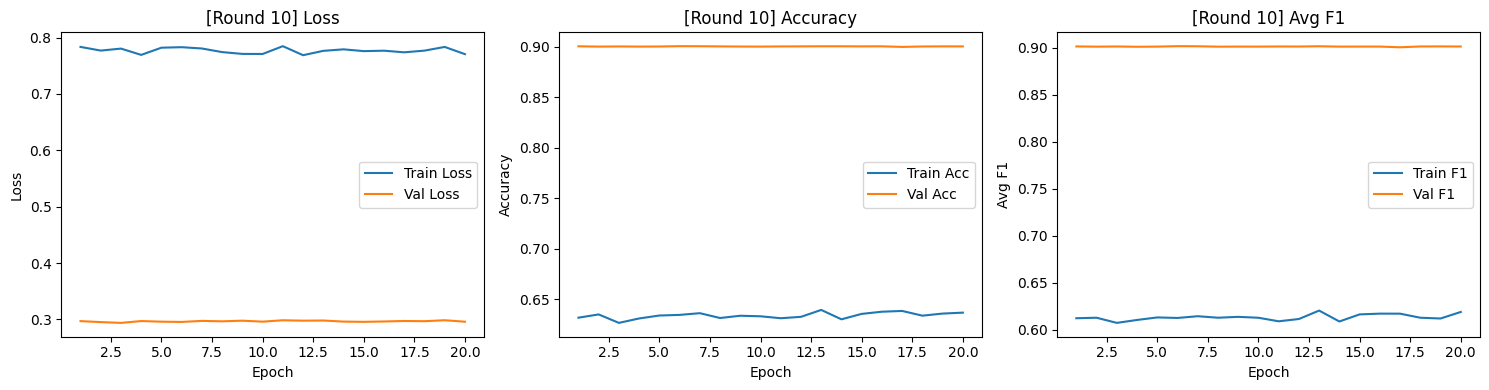

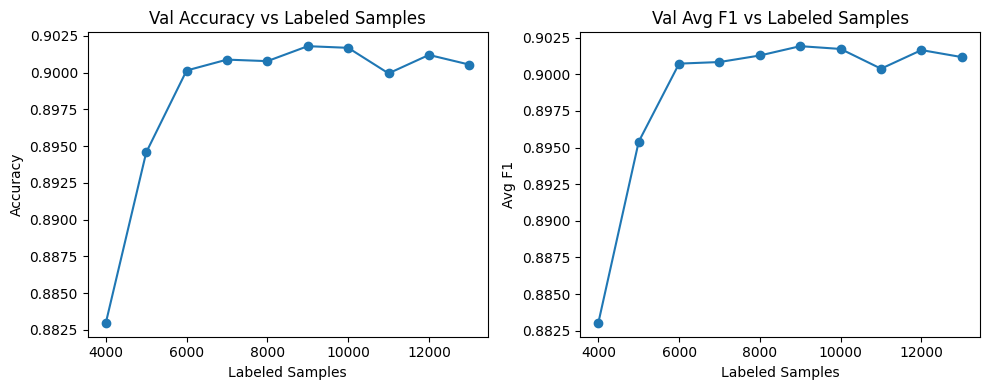

Saved labeled data for margin to deterministic_CNN_data_margin.npz

=== Running strategy: ENTROPY ===

[AL Round 0/9] — Labeled samples: 4000



Epoch 20/20
Train — Loss: 0.2112 | Acc: 0.9015 | Avg F1: 0.9073
Val   — Loss: 0.3279 | Acc: 0.8884 | Avg F1: 0.8881


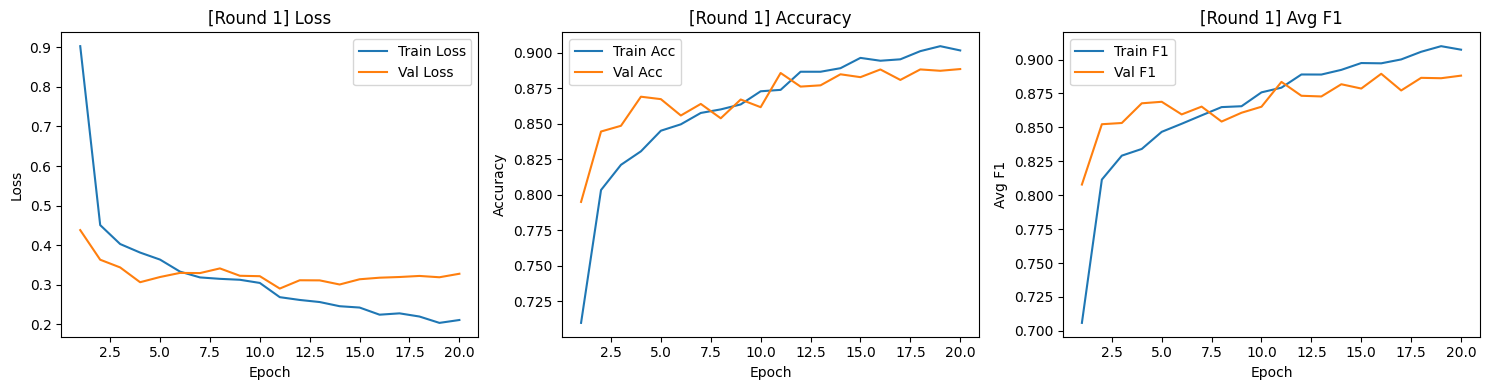


[AL Round 1/9] — Labeled samples: 5000



Epoch 20/20
Train — Loss: 0.3490 | Acc: 0.8406 | Avg F1: 0.8358
Val   — Loss: 0.3438 | Acc: 0.8699 | Avg F1: 0.8746


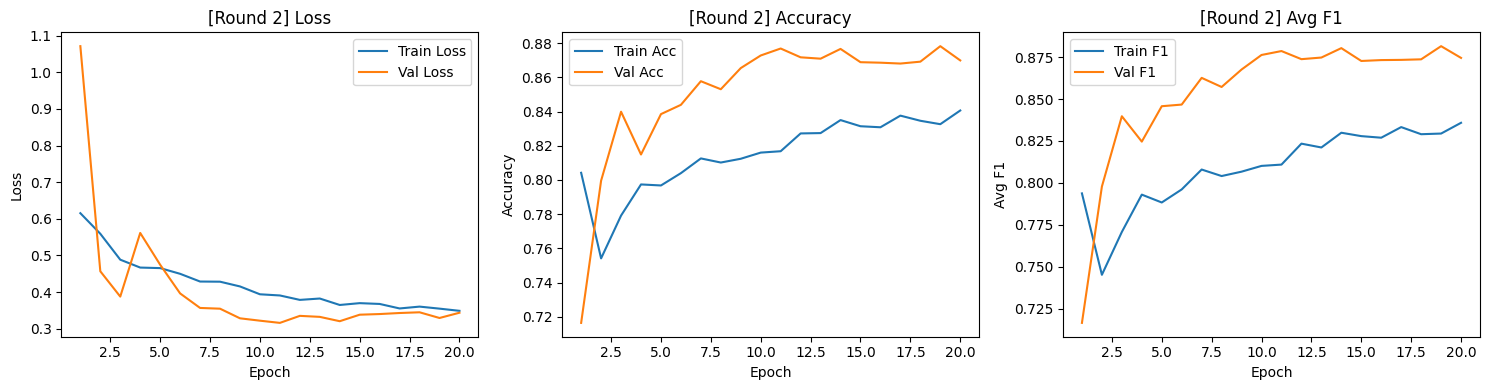


[AL Round 2/9] — Labeled samples: 6000



Epoch 20/20
Train — Loss: 0.4882 | Acc: 0.7665 | Avg F1: 0.7530
Val   — Loss: 0.3229 | Acc: 0.8840 | Avg F1: 0.8871


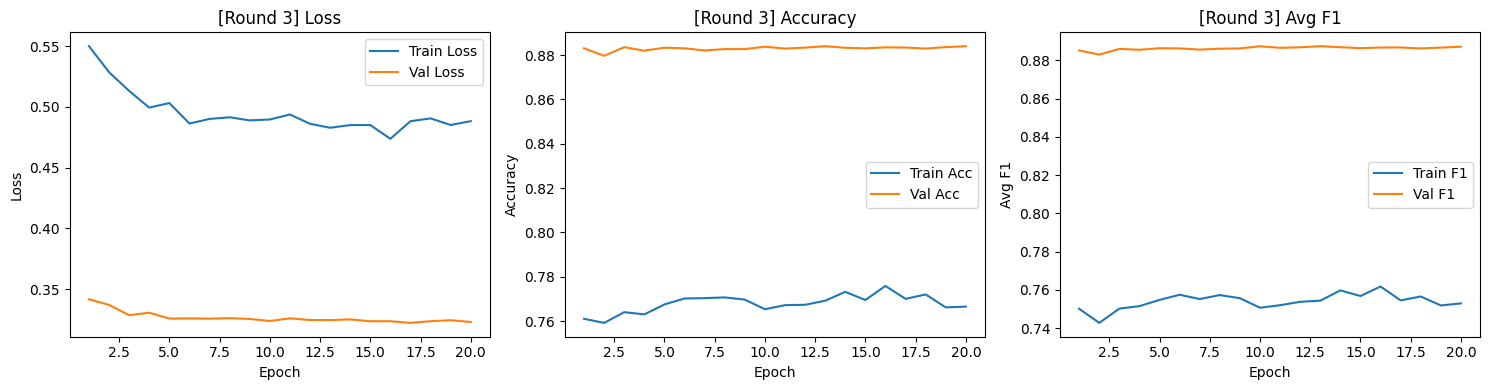


[AL Round 3/9] — Labeled samples: 7000



Epoch 20/20
Train — Loss: 0.6020 | Acc: 0.7174 | Avg F1: 0.6988
Val   — Loss: 0.3206 | Acc: 0.8896 | Avg F1: 0.8921


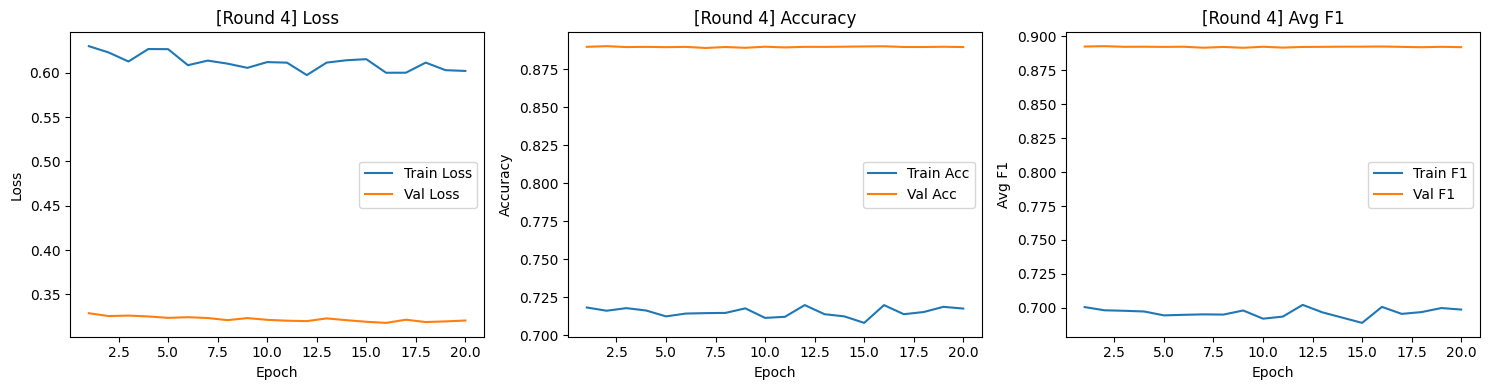


[AL Round 4/9] — Labeled samples: 8000



Epoch 20/20
Train — Loss: 0.7060 | Acc: 0.6784 | Avg F1: 0.6576
Val   — Loss: 0.3478 | Acc: 0.8846 | Avg F1: 0.8880


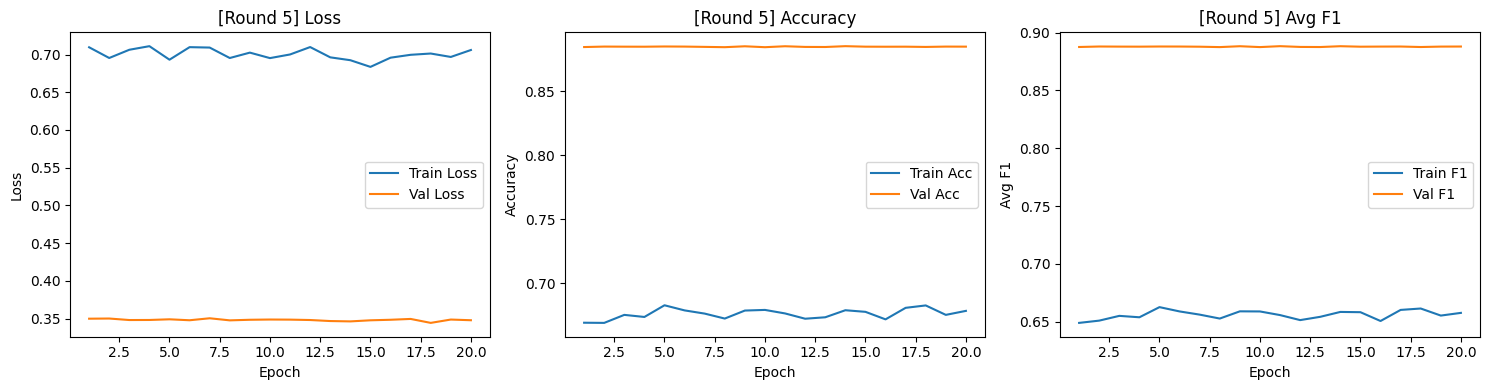


[AL Round 5/9] — Labeled samples: 9000



Epoch 20/20
Train — Loss: 0.7651 | Acc: 0.6517 | Avg F1: 0.6317
Val   — Loss: 0.3639 | Acc: 0.8856 | Avg F1: 0.8895


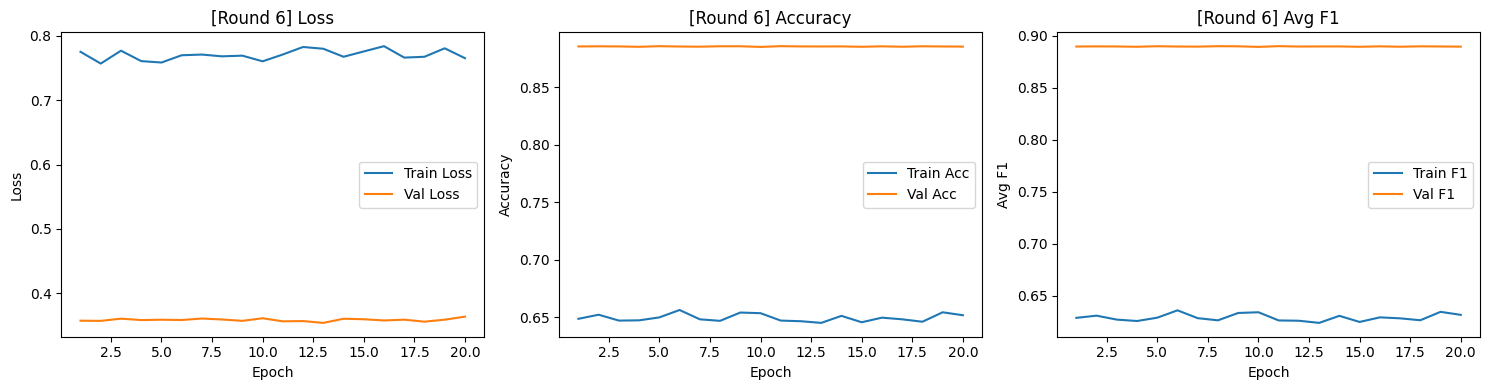


[AL Round 6/9] — Labeled samples: 10000



Epoch 20/20
Train — Loss: 0.8277 | Acc: 0.6233 | Avg F1: 0.6042
Val   — Loss: 0.3883 | Acc: 0.8841 | Avg F1: 0.8880


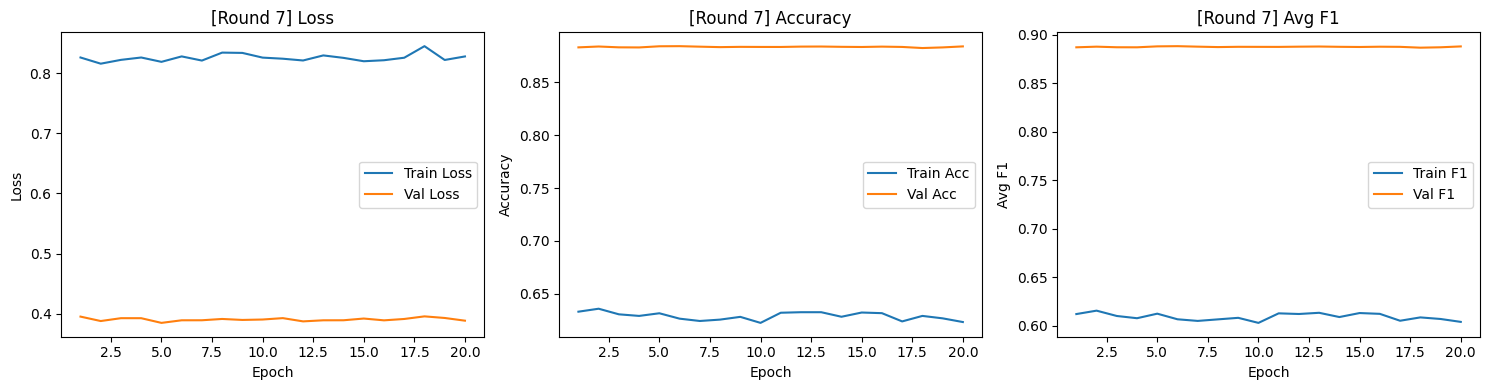


[AL Round 7/9] — Labeled samples: 11000



Epoch 20/20
Train — Loss: 0.8612 | Acc: 0.6118 | Avg F1: 0.5939
Val   — Loss: 0.4123 | Acc: 0.8806 | Avg F1: 0.8866


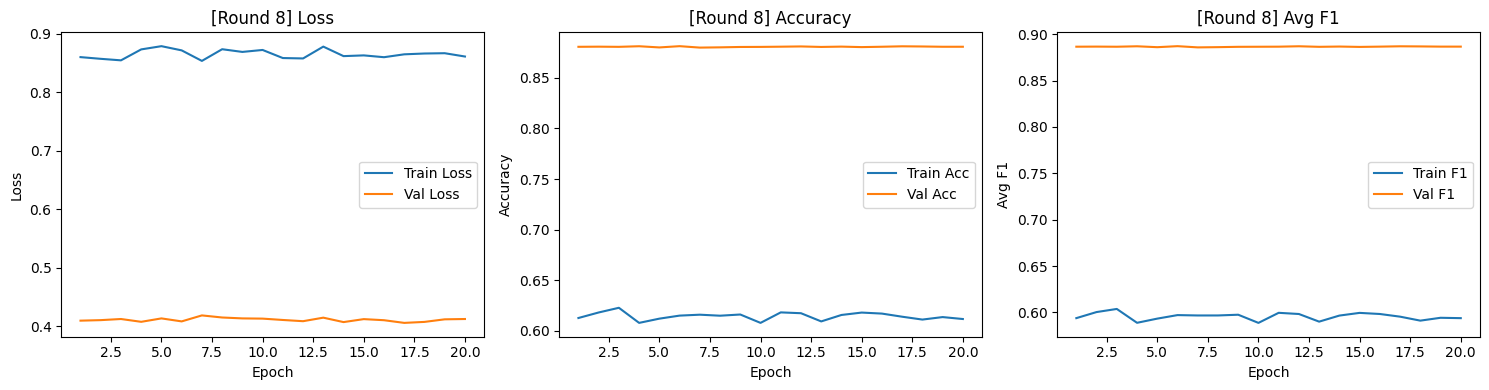


[AL Round 8/9] — Labeled samples: 12000



Epoch 20/20
Train — Loss: 0.9049 | Acc: 0.5965 | Avg F1: 0.5790
Val   — Loss: 0.4573 | Acc: 0.8768 | Avg F1: 0.8814


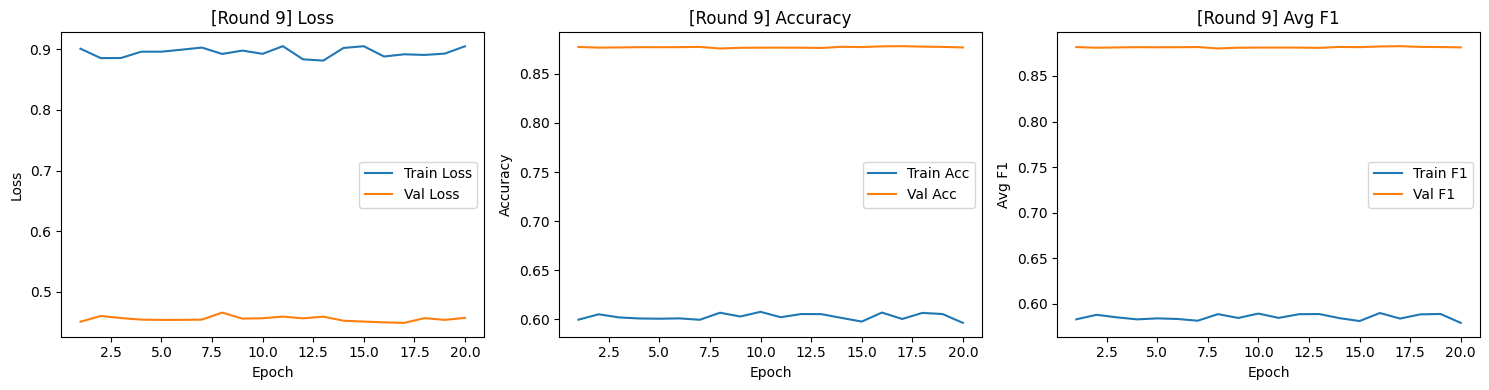


[AL Round 9/9] — Labeled samples: 13000



Epoch 20/20
Train — Loss: 0.9370 | Acc: 0.5834 | Avg F1: 0.5686
Val   — Loss: 0.4869 | Acc: 0.8721 | Avg F1: 0.8749


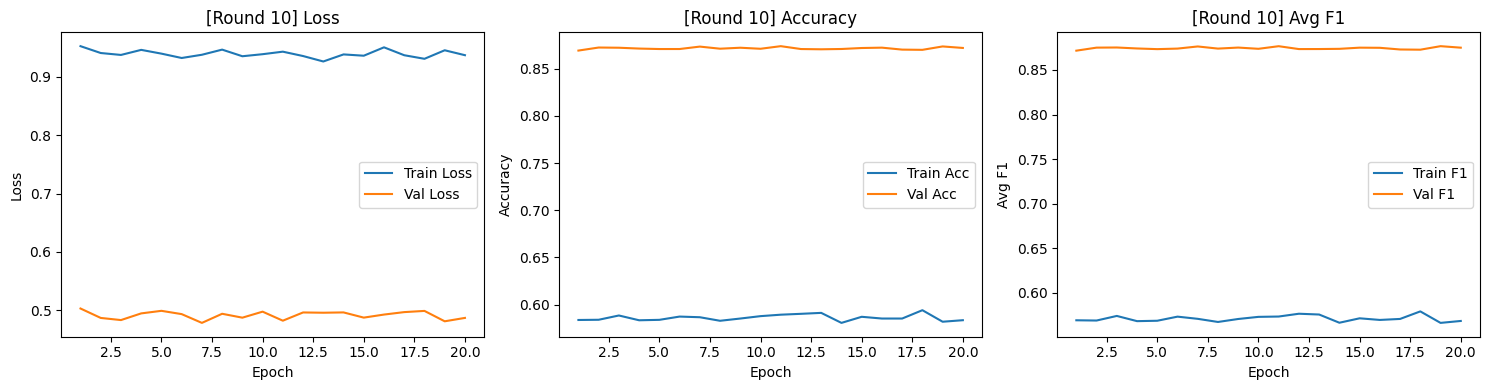

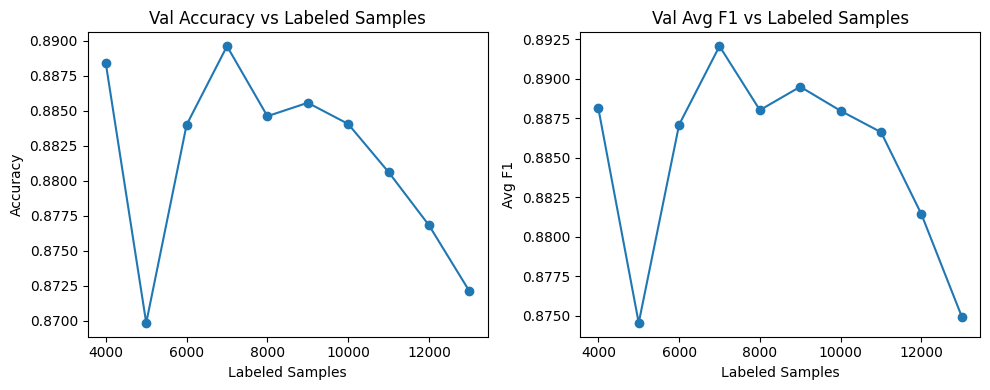

Saved labeled data for entropy to deterministic_CNN_data_entropy.npz

=== Running strategy: ENTROPY_DIVERSITY ===

[AL Round 0/9] — Labeled samples: 4000



Epoch 20/20
Train — Loss: 0.2099 | Acc: 0.9010 | Avg F1: 0.9061
Val   — Loss: 0.3132 | Acc: 0.8762 | Avg F1: 0.8701


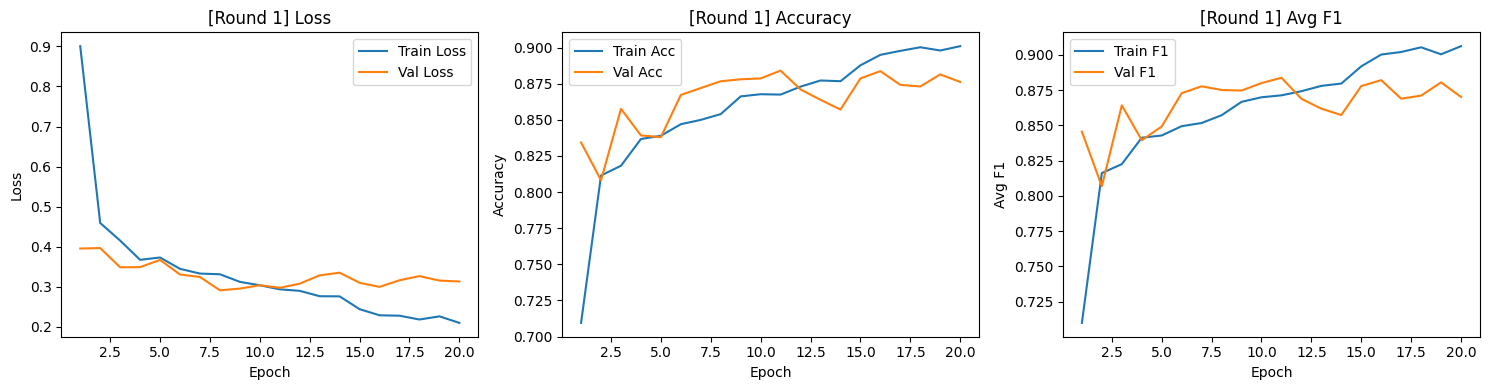


[AL Round 1/9] — Labeled samples: 5000



Epoch 20/20
Train — Loss: 0.3083 | Acc: 0.8612 | Avg F1: 0.8627
Val   — Loss: 0.3318 | Acc: 0.8869 | Avg F1: 0.8877


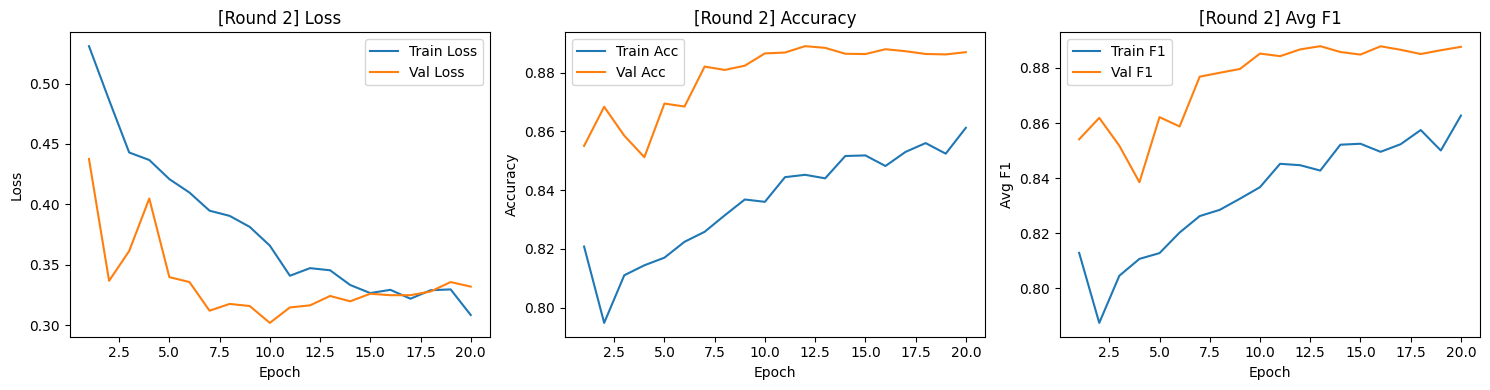


[AL Round 2/9] — Labeled samples: 6000



Epoch 20/20
Train — Loss: 0.4472 | Acc: 0.7950 | Avg F1: 0.7870
Val   — Loss: 0.3060 | Acc: 0.8937 | Avg F1: 0.8950


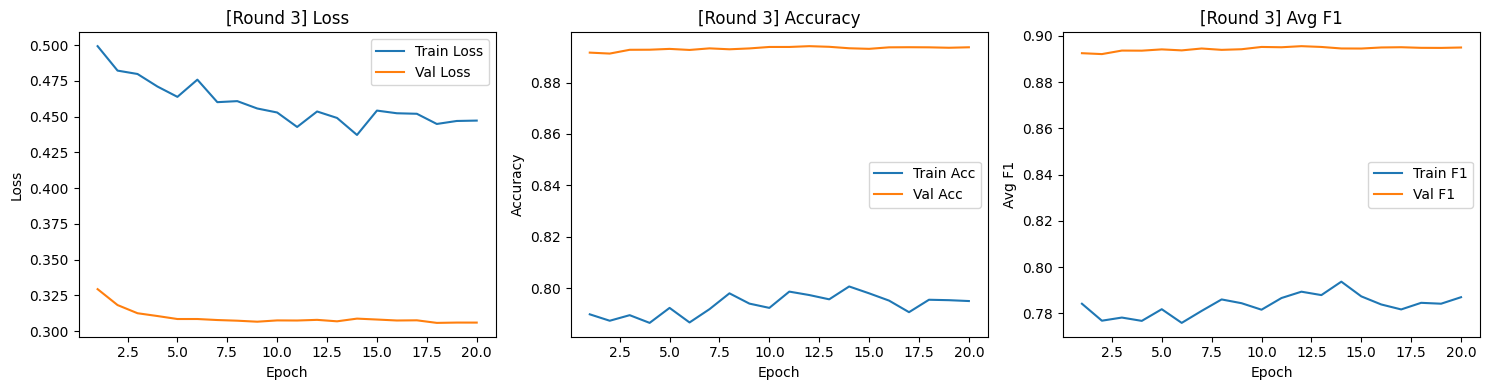


[AL Round 3/9] — Labeled samples: 7000



Epoch 20/20
Train — Loss: 0.5647 | Acc: 0.7404 | Avg F1: 0.7250
Val   — Loss: 0.3124 | Acc: 0.8927 | Avg F1: 0.8946


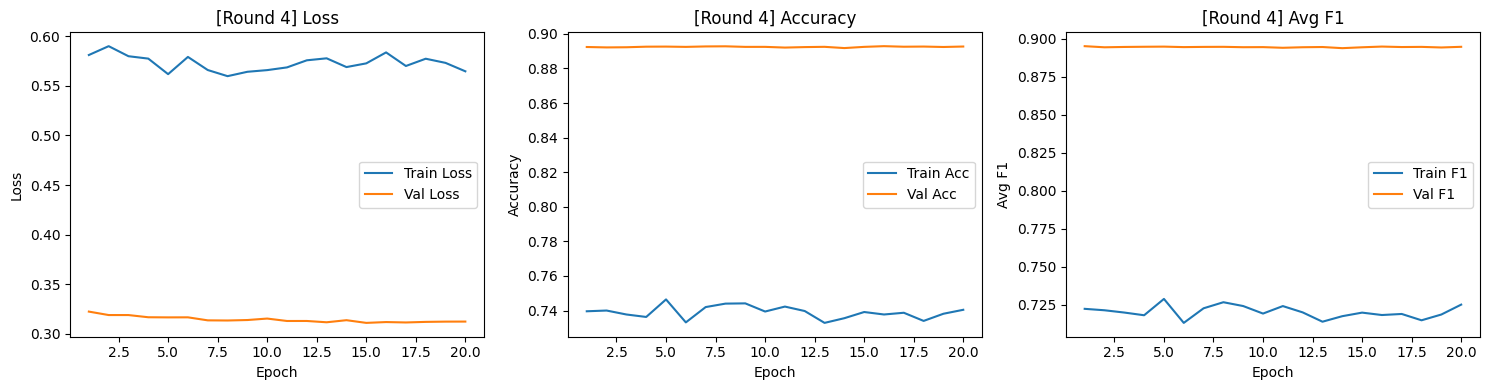


[AL Round 4/9] — Labeled samples: 8000



Epoch 20/20
Train — Loss: 0.6451 | Acc: 0.7049 | Avg F1: 0.6822
Val   — Loss: 0.3266 | Acc: 0.8900 | Avg F1: 0.8926


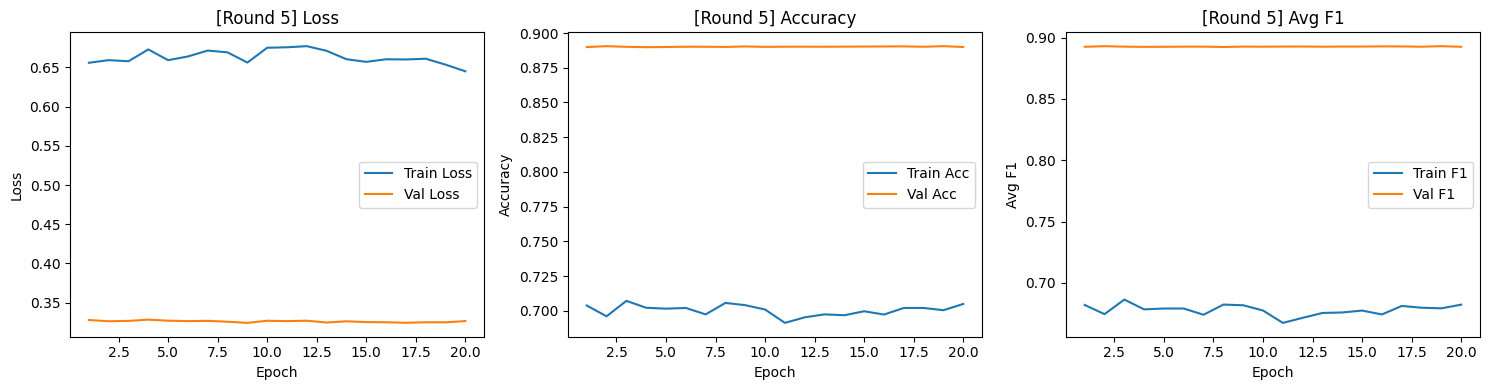


[AL Round 5/9] — Labeled samples: 9000



Epoch 20/20
Train — Loss: 0.7345 | Acc: 0.6682 | Avg F1: 0.6436
Val   — Loss: 0.3413 | Acc: 0.8853 | Avg F1: 0.8888


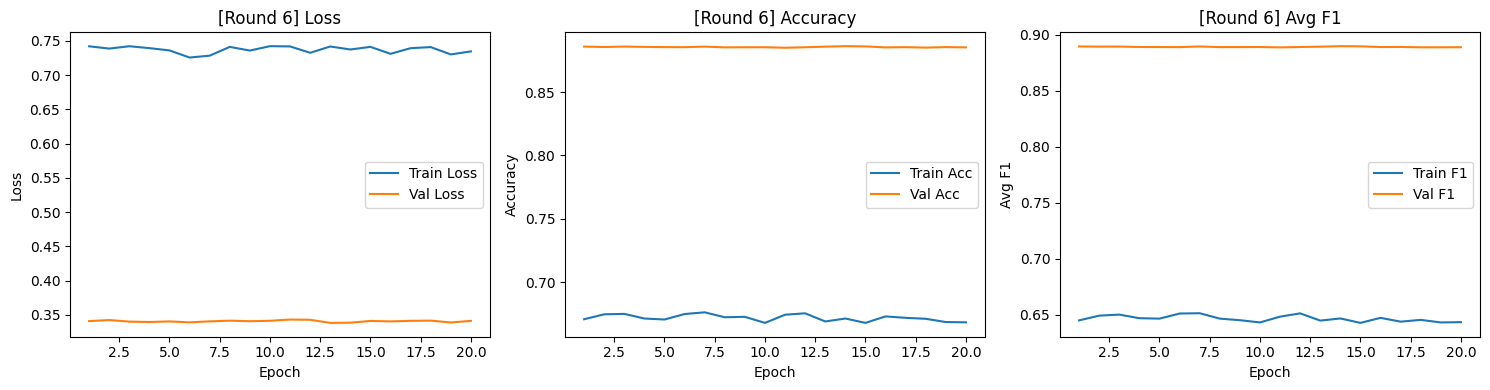


[AL Round 6/9] — Labeled samples: 10000



Epoch 20/20
Train — Loss: 0.7817 | Acc: 0.6503 | Avg F1: 0.6254
Val   — Loss: 0.3506 | Acc: 0.8820 | Avg F1: 0.8854


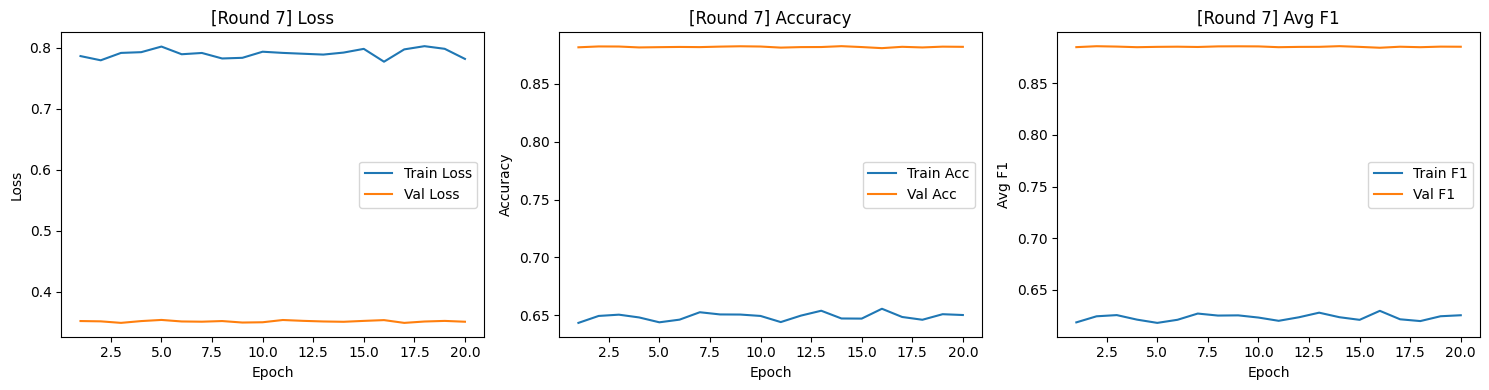


[AL Round 7/9] — Labeled samples: 11000



Epoch 20/20
Train — Loss: 0.8203 | Acc: 0.6284 | Avg F1: 0.6042
Val   — Loss: 0.3684 | Acc: 0.8760 | Avg F1: 0.8794


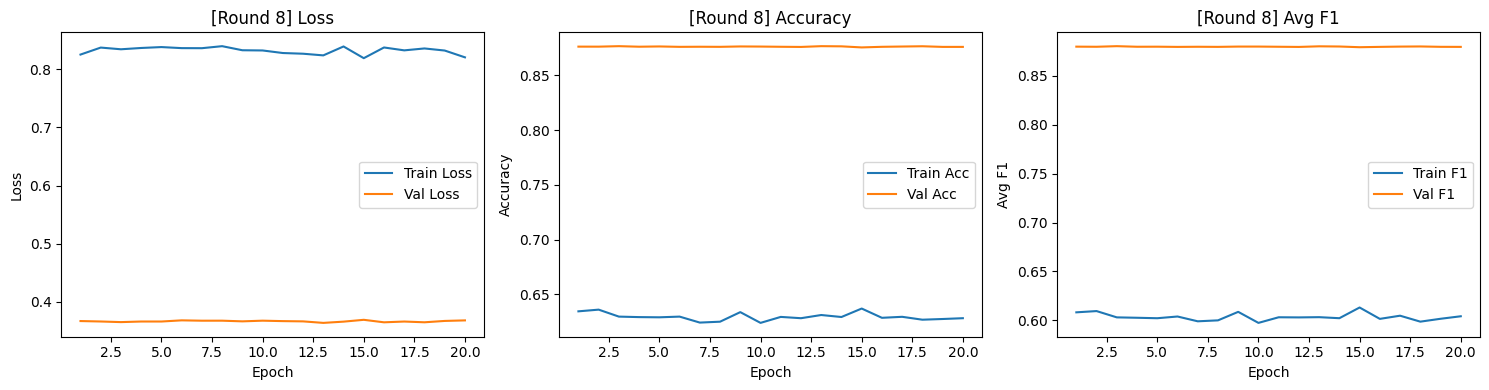


[AL Round 8/9] — Labeled samples: 12000



Epoch 20/20
Train — Loss: 0.8590 | Acc: 0.6155 | Avg F1: 0.5896
Val   — Loss: 0.3470 | Acc: 0.8832 | Avg F1: 0.8833


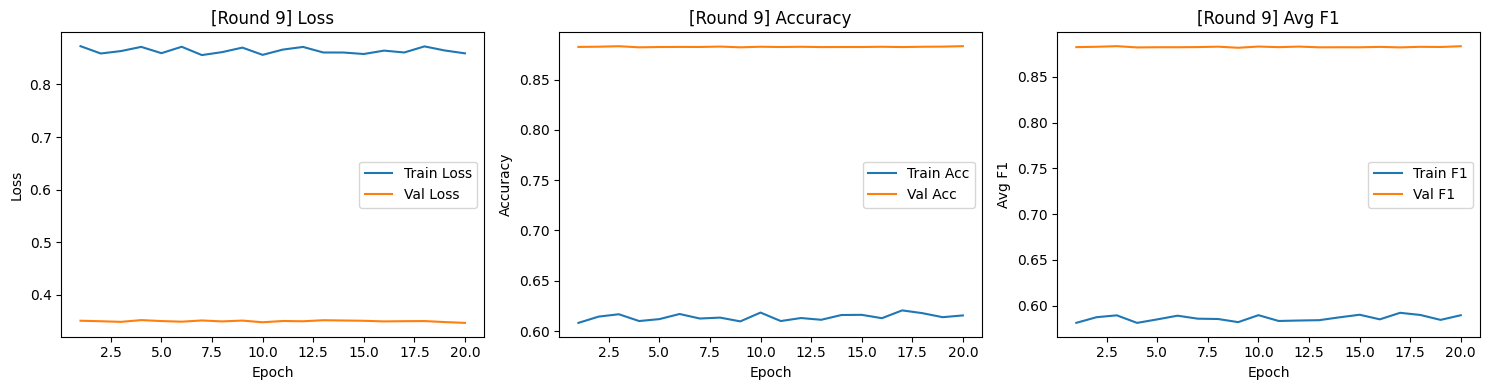


[AL Round 9/9] — Labeled samples: 13000



Epoch 20/20
Train — Loss: 0.8768 | Acc: 0.6039 | Avg F1: 0.5745
Val   — Loss: 0.3163 | Acc: 0.8885 | Avg F1: 0.8846


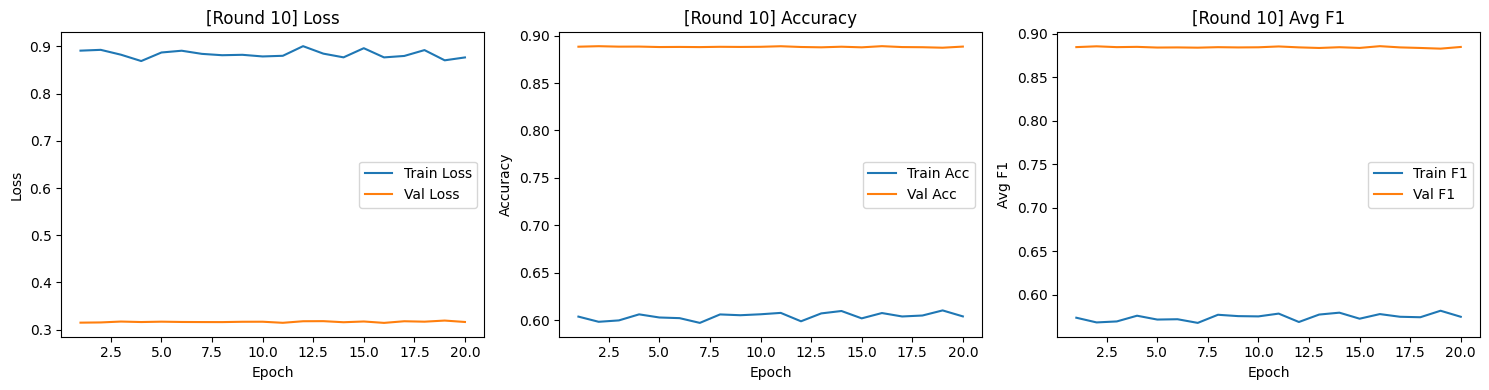

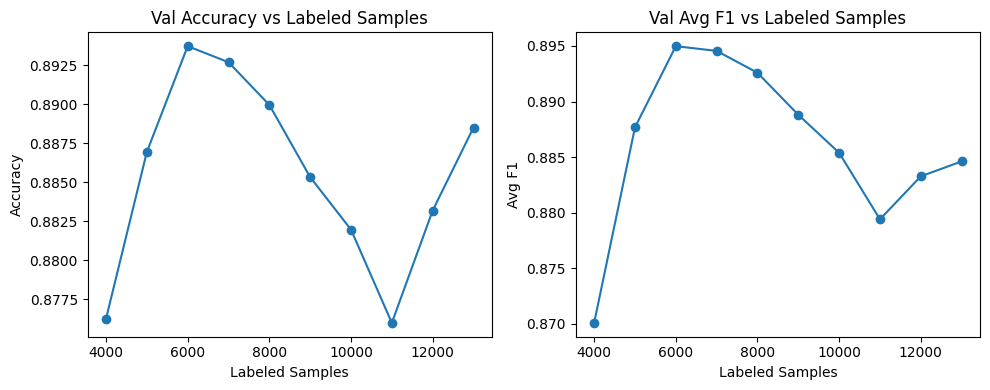

Saved labeled data for entropy_diversity to deterministic_CNN_data_entropy_diversity.npz

=== Running strategy: DIVERSITY ===

[AL Round 0/9] — Labeled samples: 4000



Epoch 20/20
Train — Loss: 0.2151 | Acc: 0.8975 | Avg F1: 0.9023
Val   — Loss: 0.3342 | Acc: 0.8730 | Avg F1: 0.8651


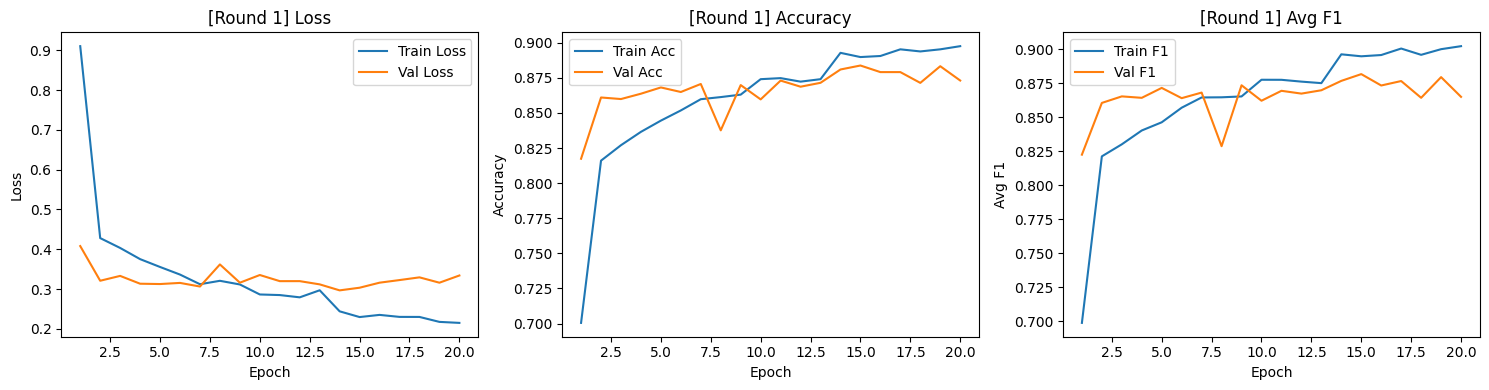


[AL Round 1/9] — Labeled samples: 5000



Epoch 20/20
Train — Loss: 0.1835 | Acc: 0.9156 | Avg F1: 0.9198
Val   — Loss: 0.3784 | Acc: 0.8787 | Avg F1: 0.8839


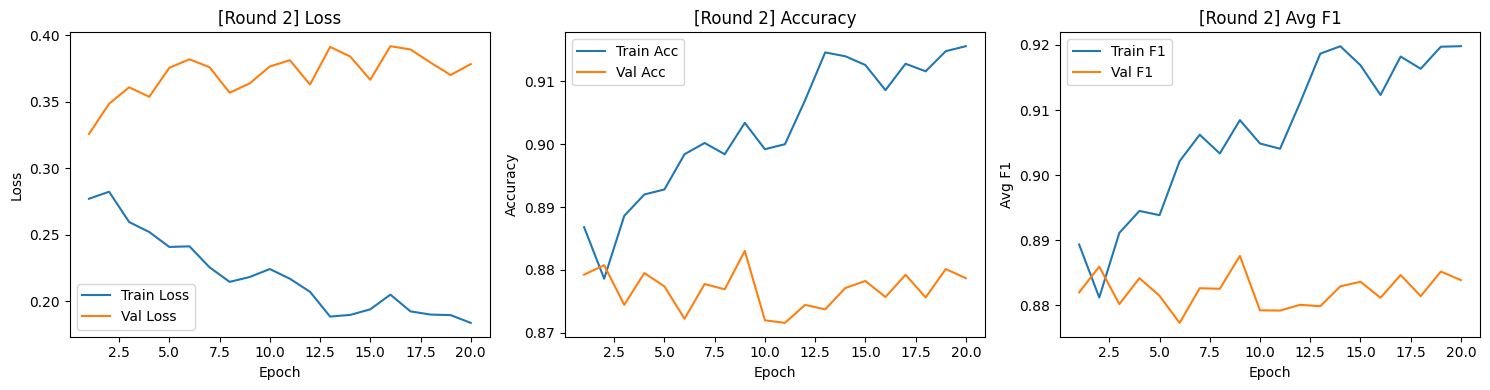


[AL Round 2/9] — Labeled samples: 6000



Epoch 20/20
Train — Loss: 0.2087 | Acc: 0.9093 | Avg F1: 0.9129
Val   — Loss: 0.3117 | Acc: 0.8932 | Avg F1: 0.8960


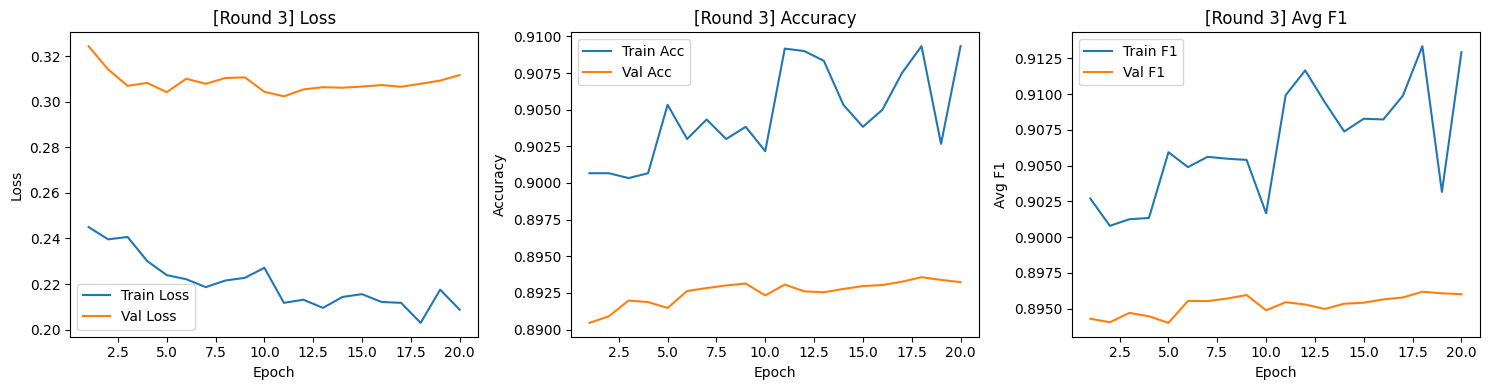


[AL Round 3/9] — Labeled samples: 7000



Epoch 20/20
Train — Loss: 0.2537 | Acc: 0.8951 | Avg F1: 0.8942
Val   — Loss: 0.3079 | Acc: 0.8926 | Avg F1: 0.8952


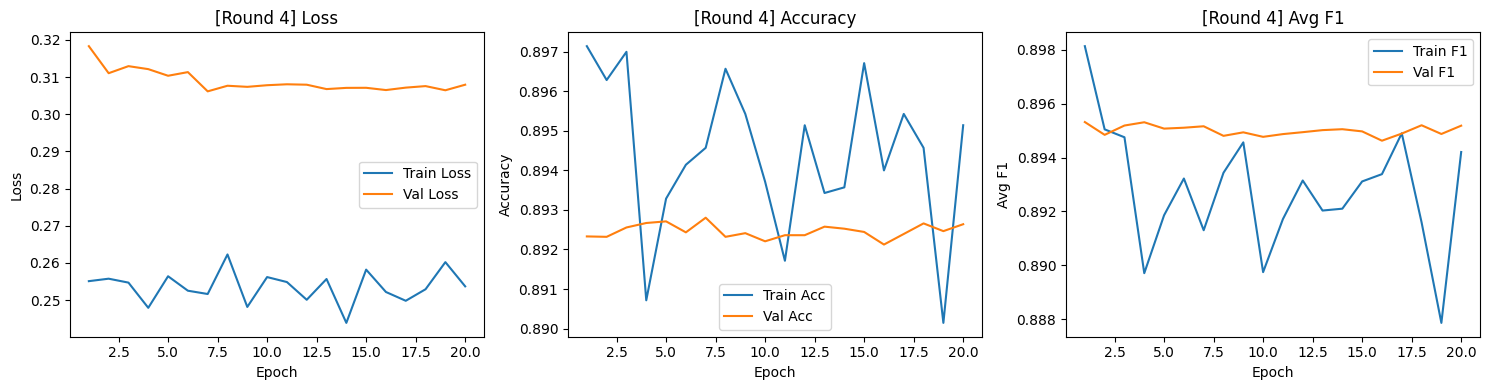


[AL Round 4/9] — Labeled samples: 8000



Epoch 20/20
Train — Loss: 0.2819 | Acc: 0.8874 | Avg F1: 0.8829
Val   — Loss: 0.3042 | Acc: 0.8935 | Avg F1: 0.8958


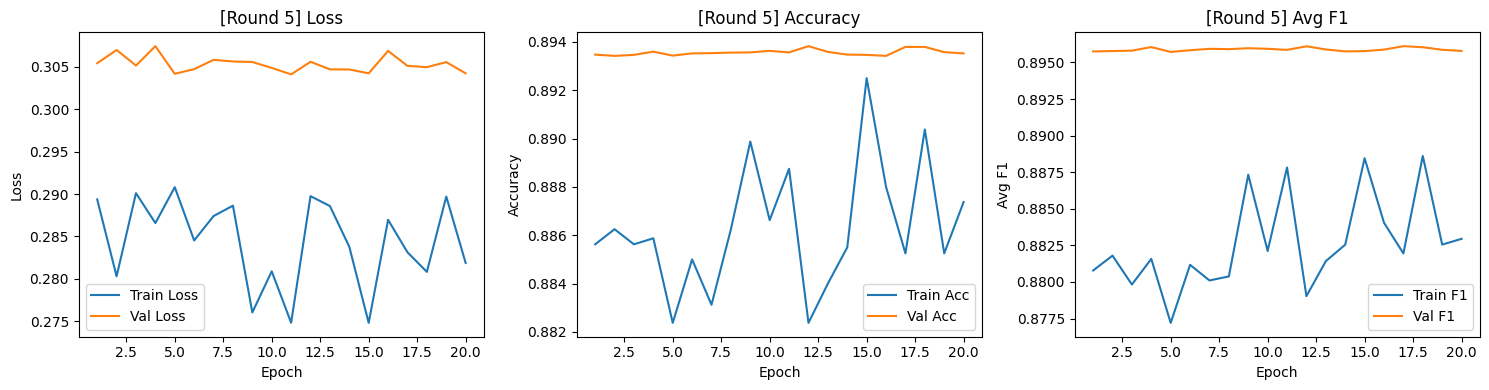


[AL Round 5/9] — Labeled samples: 9000



Epoch 20/20
Train — Loss: 0.3098 | Acc: 0.8818 | Avg F1: 0.8736
Val   — Loss: 0.3089 | Acc: 0.8937 | Avg F1: 0.8963


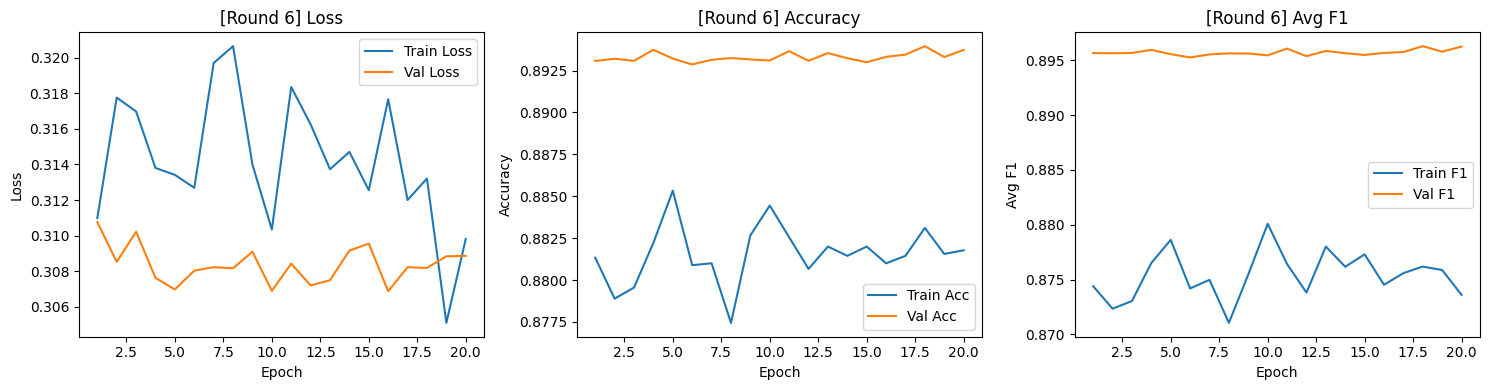


[AL Round 6/9] — Labeled samples: 10000



Epoch 20/20
Train — Loss: 0.3391 | Acc: 0.8775 | Avg F1: 0.8690
Val   — Loss: 0.3099 | Acc: 0.8930 | Avg F1: 0.8951


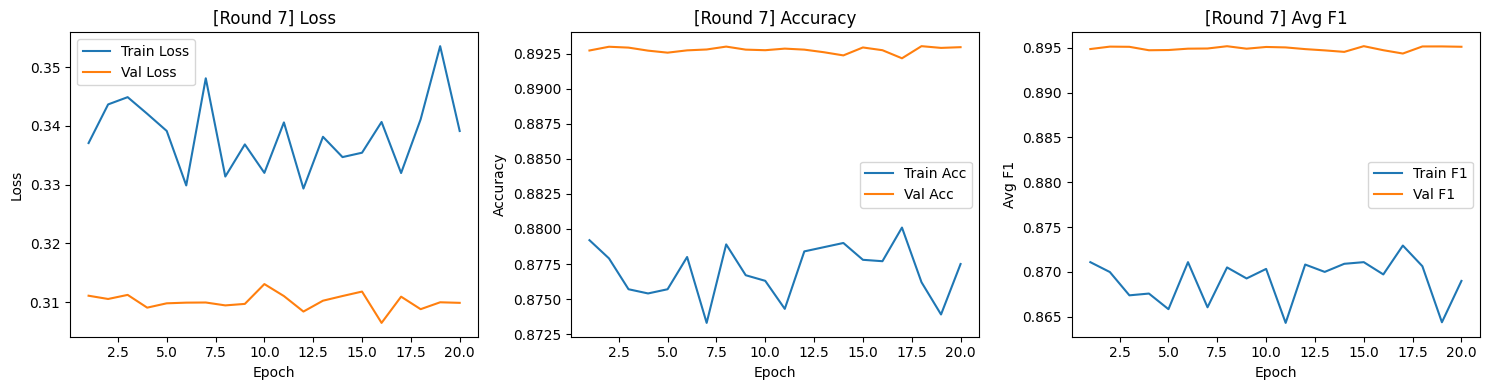


[AL Round 7/9] — Labeled samples: 11000



Epoch 20/20
Train — Loss: 0.3467 | Acc: 0.8766 | Avg F1: 0.8677
Val   — Loss: 0.3071 | Acc: 0.8940 | Avg F1: 0.8960


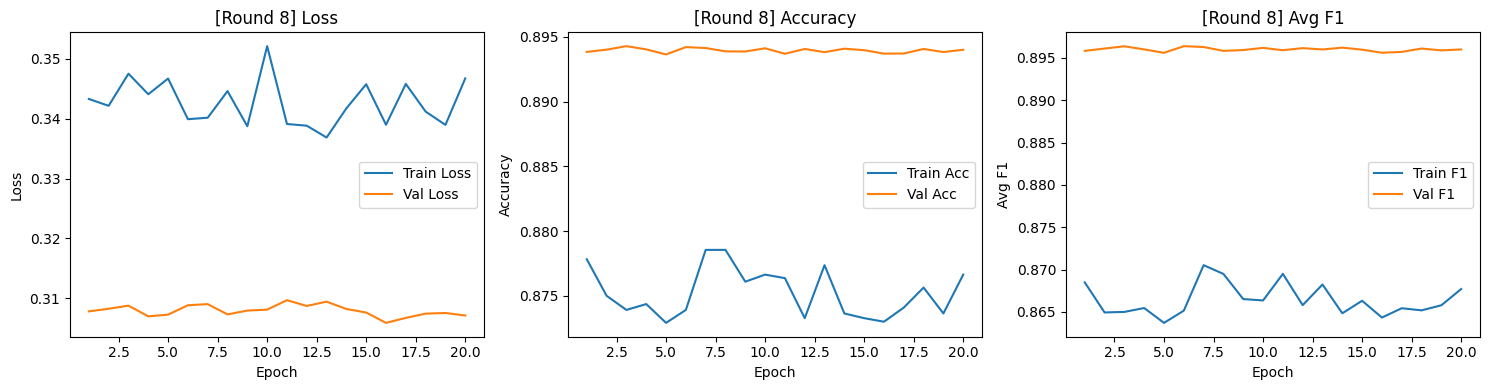


[AL Round 8/9] — Labeled samples: 12000



Epoch 20/20
Train — Loss: 0.3534 | Acc: 0.8724 | Avg F1: 0.8627
Val   — Loss: 0.3024 | Acc: 0.8936 | Avg F1: 0.8952


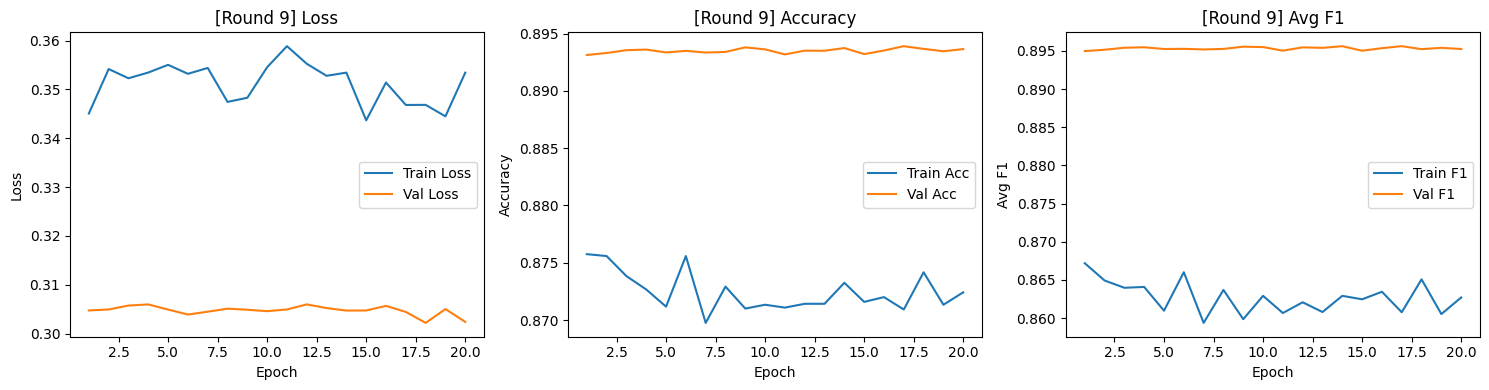


[AL Round 9/9] — Labeled samples: 13000



Epoch 20/20
Train — Loss: 0.3574 | Acc: 0.8711 | Avg F1: 0.8610
Val   — Loss: 0.3123 | Acc: 0.8926 | Avg F1: 0.8951


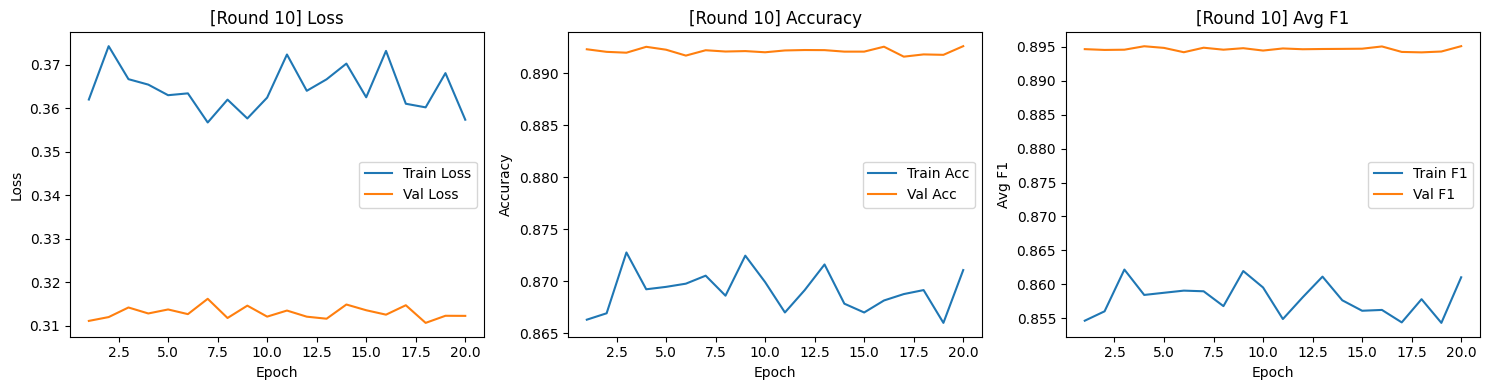

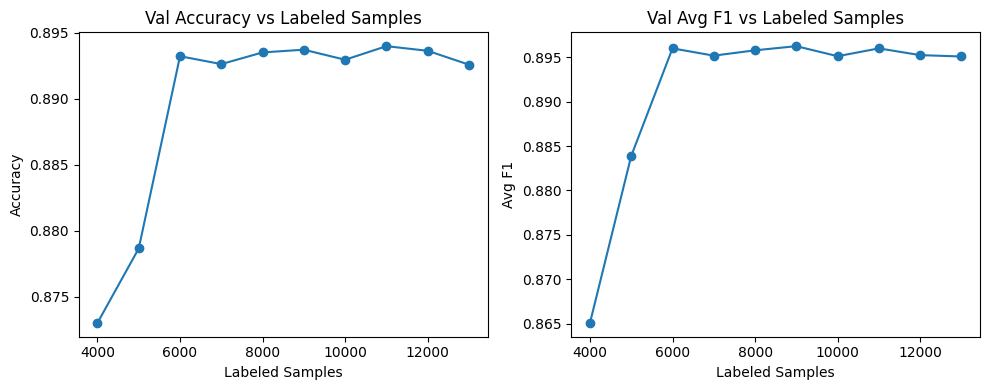

Saved labeled data for diversity to deterministic_CNN_data_diversity.npz


In [37]:
all_histories = {}

for initial_labeled, iters,query_size in data:

    if resume and os.path.exists(checkpoint_path):
        initial_labeled = load_checkpoint_data(checkpoint_path)
    
    initial_labeled= 1-initial_labeled/len(X_pool)
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)
    print(f"X_labeled shape: {X_labeled.shape}")
    print(f"y_labeled shape: {y_labeled.shape}")
    print_distribution(y_labeled, name="X_labeled")
    print(f"X_unlabeled shape: {X_unlabeled.shape}")
    print(f"y_unlabeled shape: {y_unlabeled.shape}")
    print_distribution(y_unlabeled, name="X_unlabeled")

    
    labeled_dataset = Dataset(X_labeled, y_labeled)
    unlabeled_dataset = Dataset(X_unlabeled, y_unlabeled)
    val_dataset = Dataset(X_val, y_val)

    
    
    for strat in strategies:
        print(f"\n=== Running strategy: {strat.upper()} ===")
        
        # Reset datasets to initial versions (deepcopy to avoid mutations)
        labeled = copy.deepcopy(labeled_dataset)
        unlabeled = copy.deepcopy(unlabeled_dataset)

        model.load_state_dict(copy.deepcopy(initial_state_dict))
        
        hist = active_learning_loop(
            model,
            labeled_dataset=labeled,
            unlabeled_dataset=unlabeled,
            val_dataset=val_dataset,
            strategy=strat,
            device=device,
            iters=iters,
            query_size=query_size,
            final_epochs=epochs,
            loss_mode=loss_mode,
            batch_size=batch_size
        )
        
        all_histories[(strat, initial_labeled, iters, query_size)] = hist

        labeled_X = labeled.X.numpy() 
        labeled_y = labeled.y.numpy()
    
        data_file = f"deterministic_CNN_data_{strat}.npz"
        np.savez(
            data_file,
            X=labeled_X,
            y=labeled_y
        )
        
        print(f"Saved labeled data for {strat} to {data_file}")



# Plotting final result

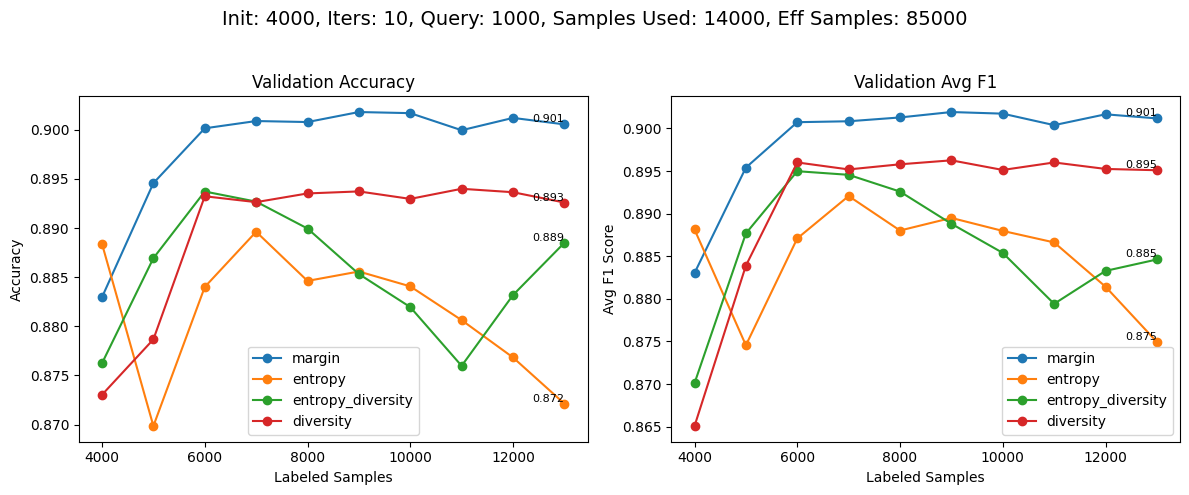

In [38]:
def eff_total_labeled_samples(init, iterations, query):
    return round(iterations * init + query * (iterations * (iterations - 1)) // 2)

def total_labeled_samples(init, iterations, query):
    return init + query * iterations

unique_configs = sorted(set((init_size, iters, query) for (_, init_size, iters, query) in all_histories.keys()))

for init_size, iters, query in unique_configs:
    plt.figure(figsize=(12, 5))

    effective_init = round(len(X_pool) * (1 - init_size))
    samples_used = total_labeled_samples(effective_init, iters, query)
    eff_samples_used = eff_total_labeled_samples(effective_init, iters, query)

    plt.suptitle(
        f"Init: {effective_init}, Iters: {iters}, Query: {query}, "
        f"Samples Used: {samples_used}, Eff Samples: {eff_samples_used}",
        fontsize=14
    )

    # Accuracy
    plt.subplot(1, 2, 1)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            samples = [r["num_labeled_samples"] for r in hist["rounds"]]
            val_acc = [r["final_val"]["acc"] for r in hist["rounds"]]
            plt.plot(samples, val_acc, label=strat, marker='o')

            # Annotate final value
            x_final, y_final = samples[-1], val_acc[-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')

    plt.title("Validation Accuracy")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")
    plt.legend()

    # F1 Score
    plt.subplot(1, 2, 2)
    for (strat, size, iters_, query_), hist in all_histories.items():
        if (size, iters_, query_) == (init_size, iters, query):
            samples = [r["num_labeled_samples"] for r in hist["rounds"]]
            val_f1 = [r["final_val"]["avg_f1"] for r in hist["rounds"]]
            plt.plot(samples, val_f1, label=strat, marker='o')

            # Annotate final value
            x_final, y_final = samples[-1], val_f1[-1]
            plt.text(x_final, y_final, f"{y_final:.3f}", fontsize=8, ha='right', va='bottom')

    plt.title("Validation Avg F1")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1 Score")
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Final Labeled dataset

X:  (14000, 28, 6)
y:  (14000,)
Before Normalisation

Global Mean: -0.0082
Global Std Dev: 0.8955

Per-Band Statistics:
  Band      Mean      Std
Band 1 -0.007580 0.924015
Band 2  0.024273 0.906839
Band 3  0.011931 0.900226
Band 4 -0.093936 0.842312
Band 5  0.012626 0.896521
Band 6  0.003563 0.895847

Class Distribution:
 Class  Count  Percentage
     0   6375   45.535714
     1   1412   10.085714
     2   6213   44.378571


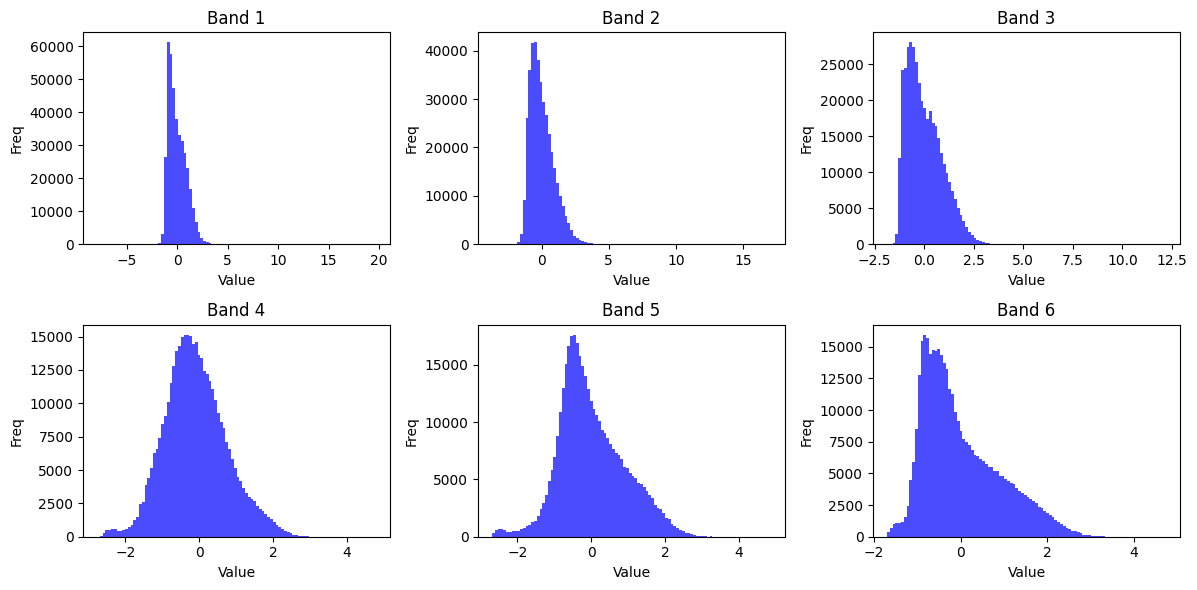

In [39]:
def load_xy_from_npz(file_path):
    """
    Load X and y from a saved .npz file.
    
    Args:
        file_path (str): Path to the .npz file.
    
    Returns:
        X (numpy.ndarray): The features array.
        y (numpy.ndarray): The labels array.
    """
    with np.load(file_path) as data:
        X = data["X"]
        y = data["y"]
    return X, y

X_final_labeled, y_final_labeled = load_xy_from_npz("/kaggle/working/deterministic_CNN_data_margin.npz")

X_final_labeled = X_final_labeled.transpose(0,2,1)

print("X: ",X_final_labeled.shape)
print("y: ",y_final_labeled.shape)


print("Before Normalisation")
print(f"\nGlobal Mean: {X_final_labeled.mean():.4f}")
print(f"Global Std Dev: {X_final_labeled.std():.4f}")
band_means, band_stds = compute_band_means_stds(X_final_labeled)
print_stats_and_class_distribution(band_means, band_stds, y_final_labeled)
plot_band_histograms(X_final_labeled)